In [112]:
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference.dataset import Dataset
from SDP_interaction_inference.correlation import Correlation
from SDP_interaction_inference import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import scipy
import tqdm
from copy import deepcopy
import matplotlib.patches

# Data loading

In [2]:
def estimate_capture(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

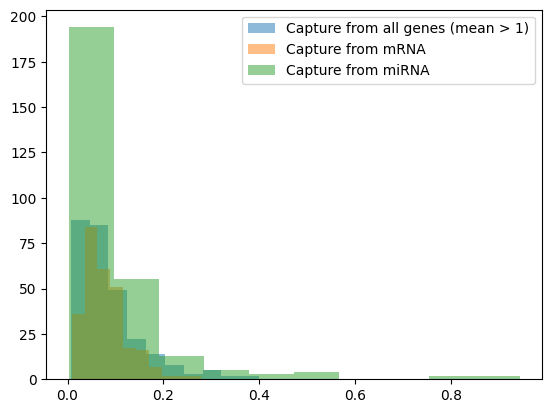

11901 genes with mean > 1 
18 miRNA 
9376 protein coding mRNA


In [3]:
# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

# read RNA types in from file
biotypes_dict = json.load(open("../../Real-Data/Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# select rows by index
data_pcRNA = data_FIB.iloc[pcRNA_indices]
data_miRNA = data_FIB.iloc[miRNA_indices]

# estimate capture
beta = estimate_capture(data_FIB)
beta_m = estimate_capture(data_pcRNA)
beta_mi = estimate_capture(data_miRNA)
plt.hist(beta, alpha=0.5, label="Capture from all genes (mean > 1)")
plt.hist(beta_m, alpha=0.5, label="Capture from mRNA")
plt.hist(beta_mi, alpha=0.5, label="Capture from miRNA")
plt.legend()
plt.show()

# amounts
print(f"{data_FIB.shape[0]} genes with mean > 1 \n{data_miRNA.shape[0]} miRNA \n{data_pcRNA.shape[0]} protein coding mRNA")

In [4]:
def construct_dataset(mirna_sample, mrna_dataset, beta, resamples=1000):

    # size
    gene_pairs, cells = mrna_dataset.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mirna_sample
        gene_j = mrna_dataset.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

# Observed correlations

Investigate the correlation structure of observed data

## All pairs

Observed correlations for all (miRNA, mRNA) pairs with a single miRNA

100%|██████████| 9376/9376 [00:30<00:00, 309.55it/s]


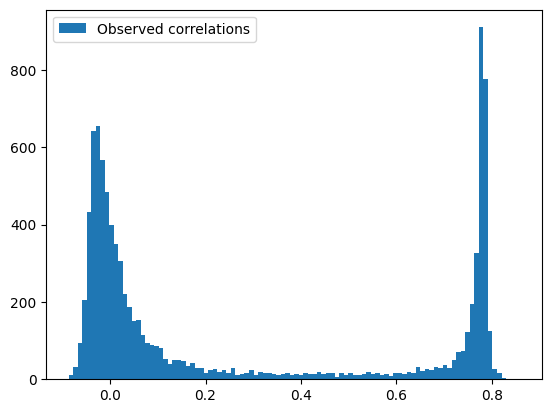

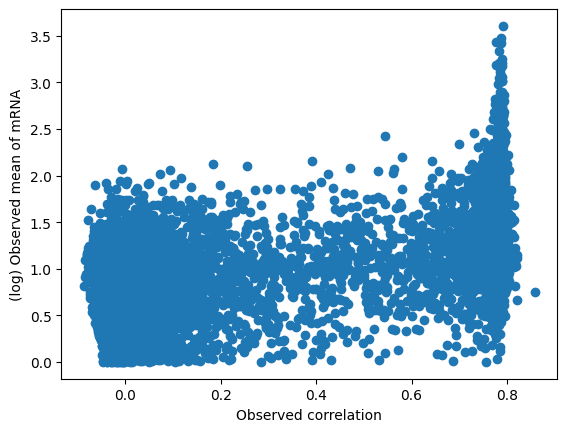

In [5]:
# genes
genes = 10000
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc[miRNA], data_pcRNA[k:k+genes], beta)

# correlations
corr = Correlation(dataset_mir, printing=False)

# correlation histogram
correlations_data = [result['statistic'] for result in corr.result_dict.values()]
plt.hist(correlations_data, label="Observed correlations", bins=100)
plt.legend()
plt.show()

# correlation vs mean of data
means = data_pcRNA[k:k+genes].mean(axis=1).tolist()
correlations_data = [result['statistic'] for result in corr.result_dict.values()]
plt.scatter(correlations_data, np.log10(means))
plt.xlabel("Observed correlation")
plt.ylabel("(log) Observed mean of mRNA")
plt.show()

Strange bimodal structure, with a large number of high positive correlations ~0.8

Correlation relatively consistent vs mean, except around this 0.8 peak

## Individual sample: 0.8 correlation

Select a sample from the highly correlated peak to investigate

In [6]:
# select a (miRNA, mRNA) pair with high correlation
corr = [x for x in correlations_data if x > 0.8][0]
idx = correlations_data.index(corr)
mRNA = data_pcRNA.iloc[idx].name

# get sample
sample_mRNA = data_pcRNA.loc[mRNA]
sample_miRNA = data_miRNA.loc[miRNA] 
print(f"pair {idx} ({miRNA}, {mRNA}) has correlation {corr}")

pair 338 (MIR100, ANKRD50) has correlation 0.8125804509612271


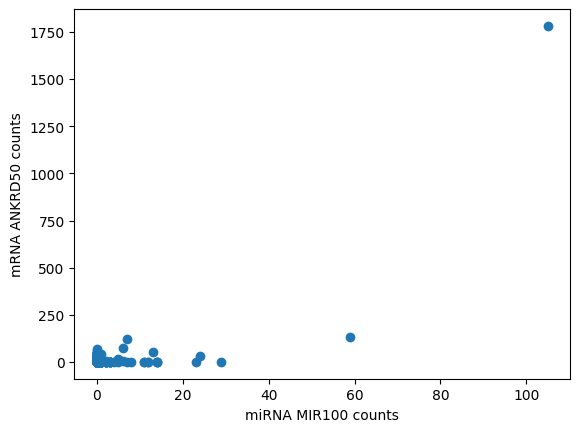

In [7]:
# display sample
plt.scatter(sample_miRNA, sample_mRNA)
plt.xlabel(f"miRNA {miRNA} counts")
plt.ylabel(f"mRNA {mRNA} counts")
plt.show()

### Outlying cells

There are outlying cells with very high counts for the miRNA and mRNA:
- 2 cells with large counts for the miRNA
- 1 of which has an extremely high mean count over all mRNA

In [8]:
# 2 cells with high miRNA count
data_miRNA.loc['MIR100'][data_miRNA.loc['MIR100'] > 50]

Fibroblasts_D14_S86      59
Fibroblasts_P23_S383    105
Name: MIR100, dtype: int64

In [9]:
# one of these is the only cell with mean mRNA count above 70, with a value of 1500
sum(data_pcRNA.mean(axis=0) >= 70), float(data_pcRNA.mean(axis=0)['Fibroblasts_P23_S383'])

(1, 1563.5987627986349)

In [10]:
# the other does not have an outlying mean mRNA count
float(data_pcRNA.mean(axis=0)['Fibroblasts_D14_S86'])

32.05919368600683

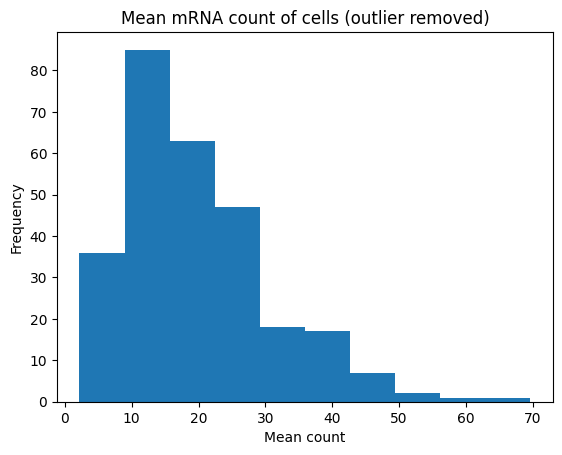

In [11]:
# mean counts of cells across mRNA (outlier removed)
plt.hist([x for x in data_pcRNA.mean(axis=0) if x < 100])
plt.xlabel("Mean count")
plt.ylabel("Frequency")
plt.title("Mean mRNA count of cells (outlier removed)")
plt.show()

#### Capture efficiency

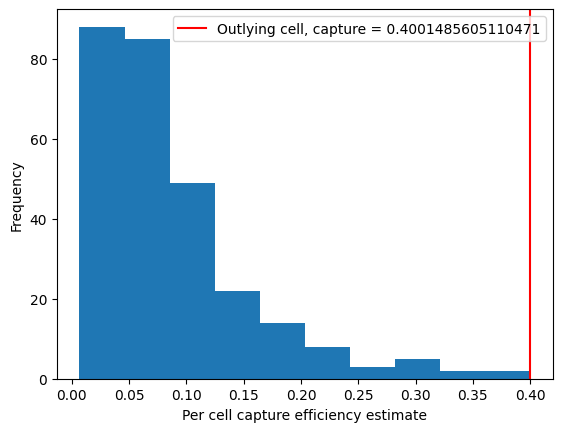

In [12]:
# capture efficiency
idx_out = data_miRNA.columns.to_list().index('Fibroblasts_P23_S383')
cap_out = beta[idx_out]
plt.hist(beta)
plt.xlabel("Per cell capture efficiency estimate")
plt.ylabel("Frequency")
plt.axvline(cap_out, color="red", label=f"Outlying cell, capture = {cap_out}")
plt.legend()
plt.show()

In [13]:
beta.max()

np.float64(0.4001485605110471)

This cell has the largest capture efficiency, as it has the largest total count

## Remove outlier cell

Remove this outlying cell and investigate effects on observed correlations

In [12]:
data_new_pcRNA = data_pcRNA.copy(deep=True)
data_new_miRNA = data_miRNA.copy(deep=True)
data_new_pcRNA = data_new_pcRNA.drop(labels=['Fibroblasts_P23_S383'], axis=1)
data_new_miRNA = data_new_miRNA.drop(labels=['Fibroblasts_P23_S383'], axis=1)

In [13]:
# compute new capture efficiency
data_new_FIB = data_FIB.drop(labels=['Fibroblasts_P23_S383'], axis=1)
beta_new = estimate_capture(data_new_FIB)

c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Individual sample

In [13]:
# get same sample but outlier removed
sample_new_mRNA = data_new_pcRNA.loc[mRNA]
sample_new_miRNA = data_new_miRNA.loc[miRNA] 
corr_new = scipy.stats.pearsonr(sample_new_miRNA, sample_new_mRNA).statistic
print(f"pair {idx} ({miRNA}, {mRNA}) has correlation {corr_new} down from {corr} when outlier cell removed")

pair 338 (MIR100, ANKRD50) has correlation 0.3997368405344432 down from 0.8125804509612271 when outlier cell removed


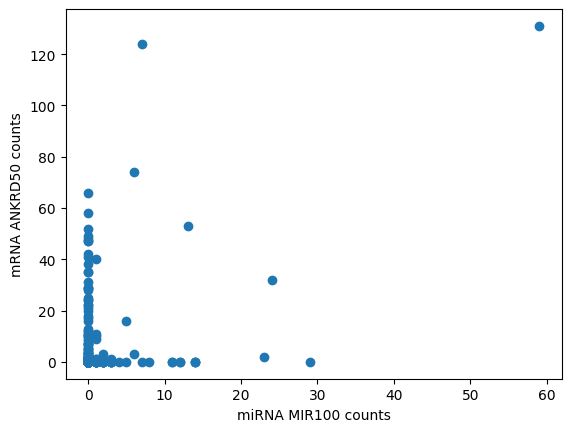

In [14]:
# display sample
plt.scatter(sample_new_miRNA, sample_new_mRNA)
plt.xlabel(f"miRNA {miRNA} counts")
plt.ylabel(f"mRNA {mRNA} counts")
plt.show()

### All pairs

100%|██████████| 9376/9376 [00:12<00:00, 768.06it/s]


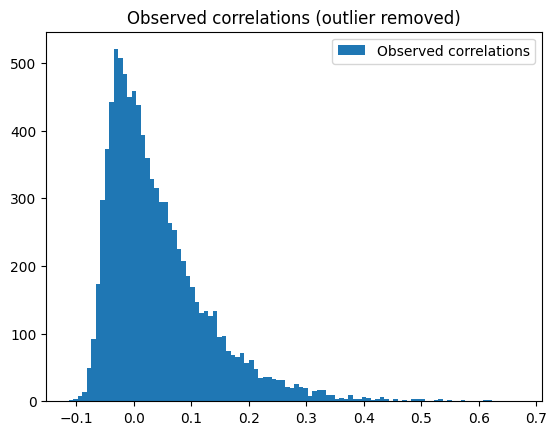

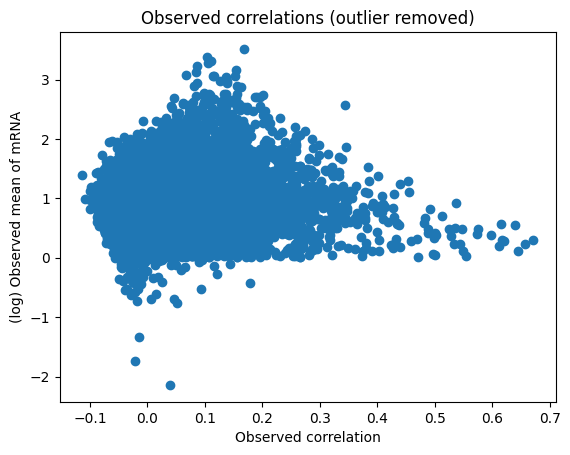

In [ ]:
# genes
genes = 10000
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_new_mir = construct_dataset(data_new_miRNA.loc[miRNA], data_new_pcRNA[k:k+genes], beta_new)

# correlations
corr_new = Correlation(dataset_new_mir, printing=False)

# correlation histogram
correlations_new_data = [result['statistic'] for result in corr_new.result_dict.values()]
plt.hist(correlations_new_data, label="Observed correlations", bins=100)
plt.title("Observed correlations (outlier removed)")
plt.legend()
plt.show()

# correlation vs mean of data
means = data_new_pcRNA[k:k+genes].mean(axis=1).tolist()
correlations_new_data = [result['statistic'] for result in corr_new.result_dict.values()]
plt.scatter(correlations_new_data, np.log10(means))
plt.xlabel("Observed correlation")
plt.ylabel("(log) Observed mean of mRNA")
plt.title("Observed correlations (outlier removed)")
plt.show()

Bimodal structure removed

Still exist samples with high correlation ~0.7, but only a few

#### Outlier removal effects on other miRNA

Bimodal structure removed from all, much more reasonable structure

Still many highly positive correlations, and few negative correlations

In [ ]:
corr_list = []

for miRNA in data_miRNA.index:
    
    # genes
    genes = 10000
    k = 0

    # construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
    dataset_other = construct_dataset(data_new_miRNA.loc[miRNA], data_new_pcRNA[k:k+genes], beta_new)

    # correlations
    corr_other = Correlation(dataset_other, printing=False)
    res_other = [result['statistic'] for result in corr_other.result_dict.values()]

    # store
    corr_list.append(res_other)

100%|██████████| 9376/9376 [00:10<00:00, 875.63it/s]


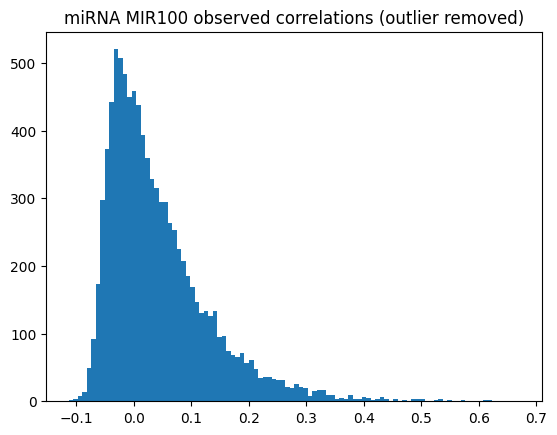

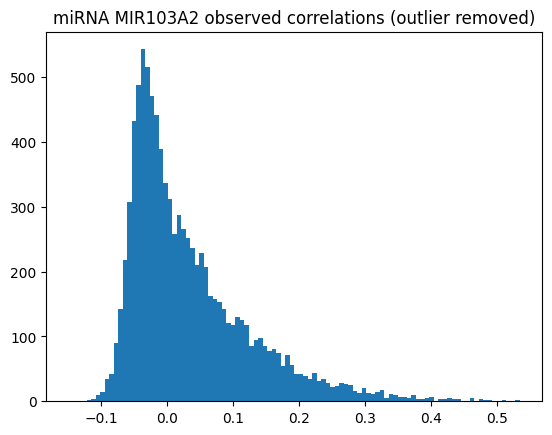

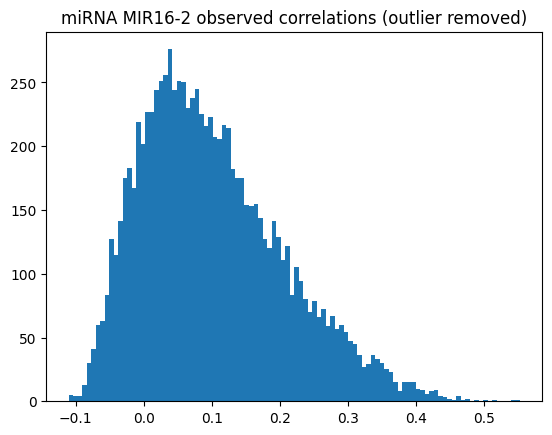

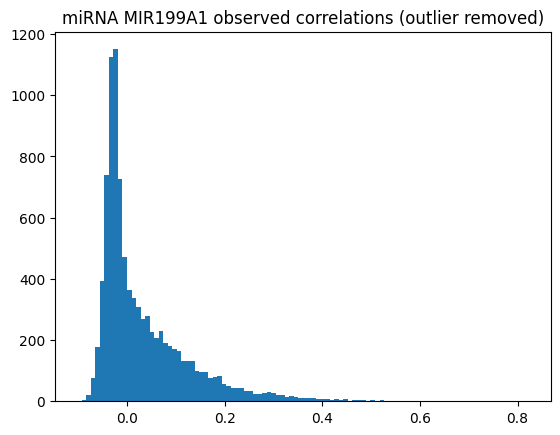

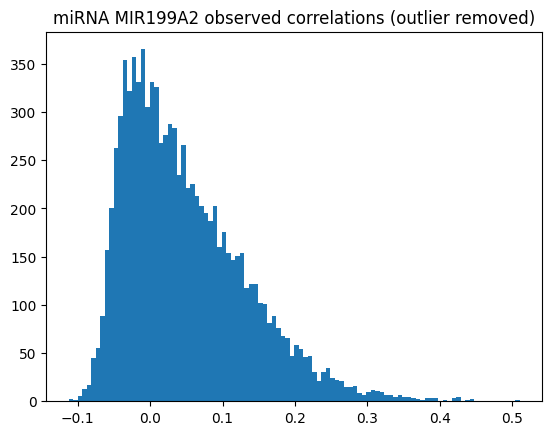

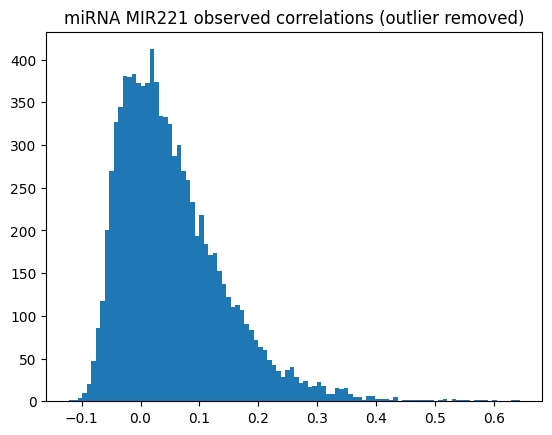

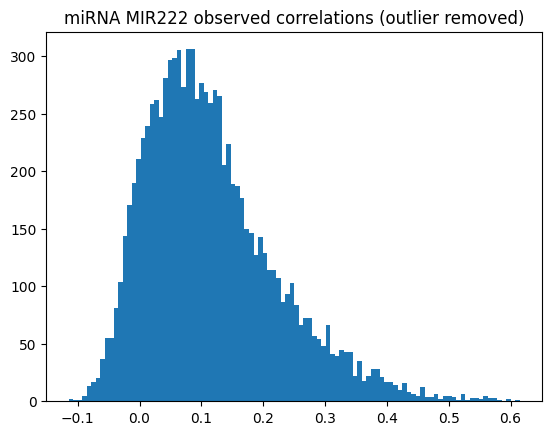

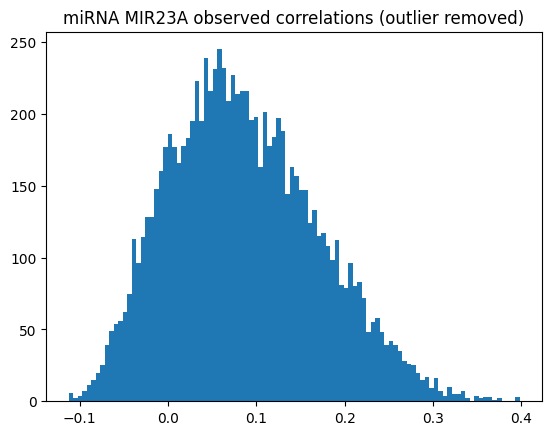

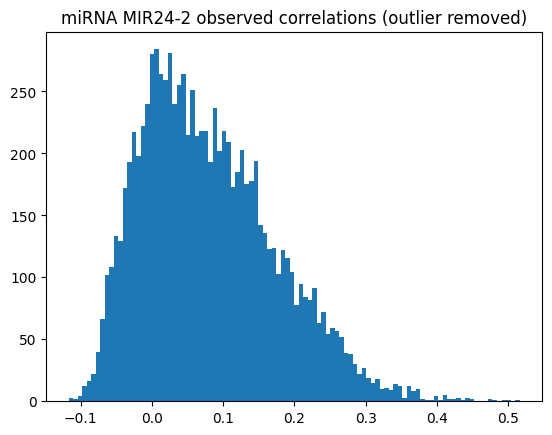

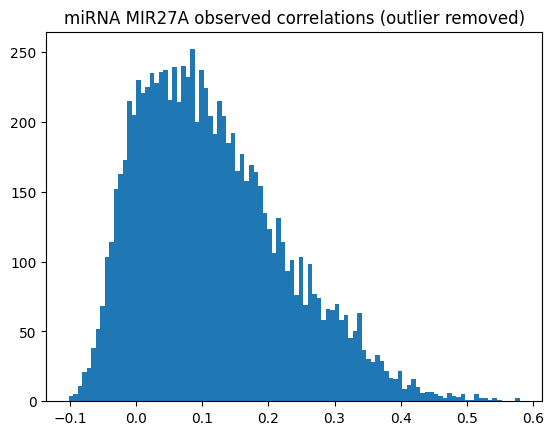

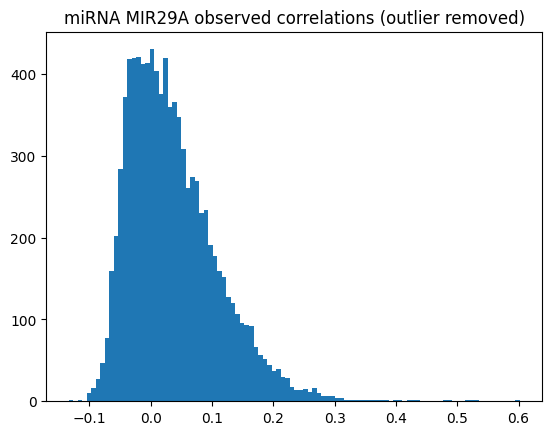

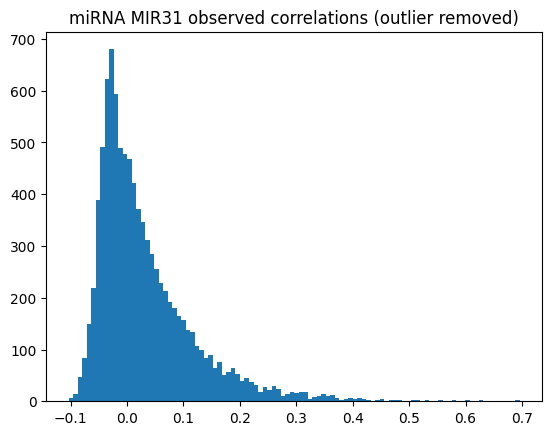

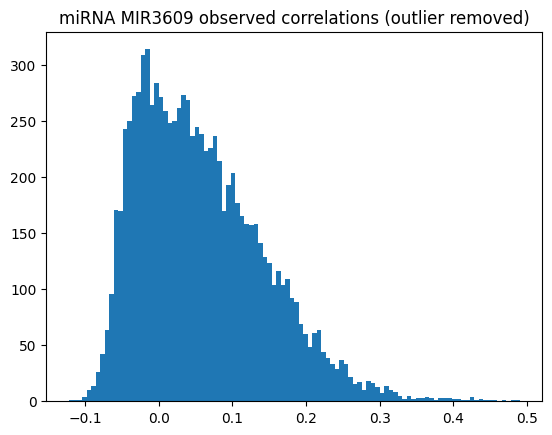

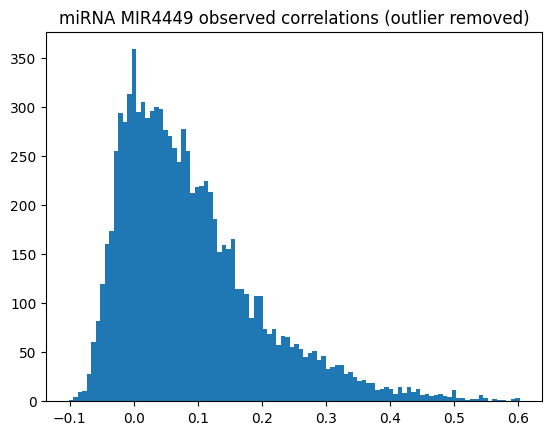

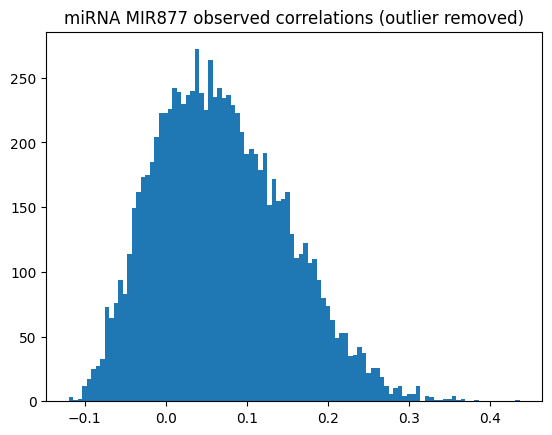

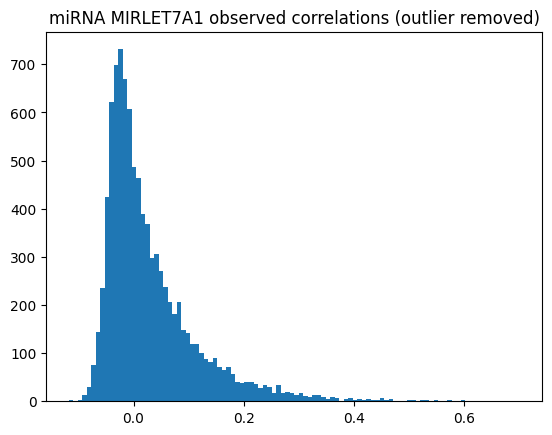

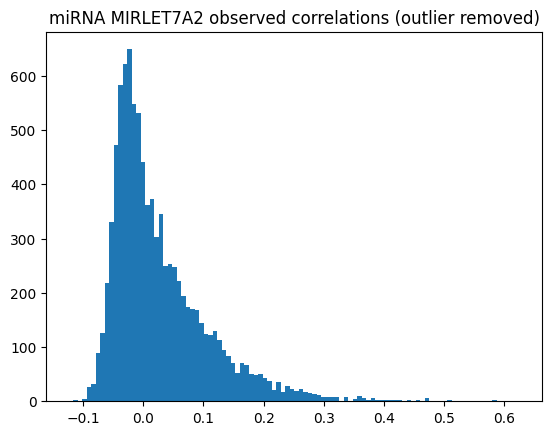

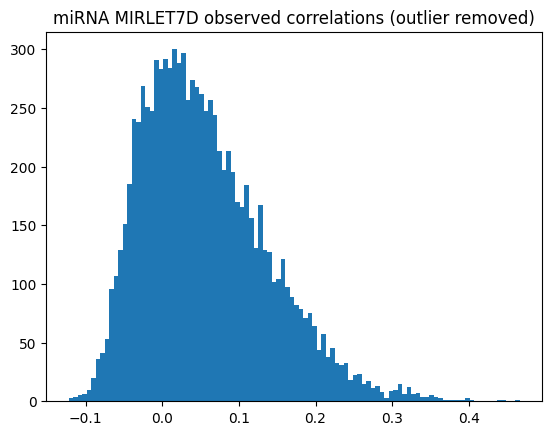

In [618]:
for i, miRNA in enumerate(data_miRNA.index):
    plt.hist(corr_list[i], bins=100)
    plt.title(f"miRNA {miRNA} observed correlations (outlier removed)")
    plt.show()

# Confidence Intervals

Investigate observed correlation intervals, beyond point estimate from sample

In [14]:
def construct_sample_dataset(sample_miRNA, sample_mRNA, beta):
    dataset_sample = Dataset()
    gene_pairs, cells = 1, len(sample_mRNA)
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )
    counts_df.iloc[0] = list(zip(sample_miRNA, sample_mRNA))
    dataset_sample.count_dataset = counts_df
    dataset_sample.cells = cells
    dataset_sample.gene_pairs = gene_pairs
    dataset_sample.beta = beta
    return dataset_sample

In [15]:
def moment_correlation_bounds(moment_bounds):
    powers = utils.compute_powers(S=2, d=2)
    i_xy = powers.index([1, 1])
    i_x  = powers.index([1, 0])
    i_y  = powers.index([0, 1])
    i_x2 = powers.index([2, 0])
    i_y2 = powers.index([0, 2])

    # collect moment values
    E_xy = moment_bounds[:, i_xy]
    E_x  = moment_bounds[:, i_x]
    E_y  = moment_bounds[:, i_y]
    E_x2 = moment_bounds[:, i_x2]
    E_y2 = moment_bounds[:, i_y2]

    # compute correlation
    correlation_lb = (E_xy[0] - E_x[1]*E_y[1]) / (np.sqrt(E_x2[1] - E_x[0]**2) * np.sqrt(E_y2[1] - E_y[0]**2))
    correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))

    return correlation_lb, correlation_ub

In [16]:
def direct_correlation_bootstrap(x1_sample, x2_sample, confidence=None, resamples=None):

    # get sample size
    n = len(x1_sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n
    # confidence level: default to 95%
    if confidence is None:
        confidence = 0.95

    # initialize random generator
    rng = np.random.default_rng()

    # separate sample pairs
    x1_sample = list(x1_sample)
    x2_sample = list(x2_sample)

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to N x n x 2 array
    boot = rng.choice(sample, size=(resamples, n))

    # compute correlations
    estimates = np.zeros(resamples)
    for i in range(resamples):

        b1 = boot[i, :, 0]
        b2 = boot[i, :, 1]

        E_xy = np.mean(b1 * b2)
        E_x = np.mean(b1)
        E_y = np.mean(b2)
        E_x2 = np.mean(b1**2)
        E_y2 = np.mean(b2**2)

        corr = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))

        #test = scipy.stats.pearsonr(boot[i, :, 0], boot[i, :, 1])
        estimates[i] = corr#test.statistic

    # take quantiles
    alpha = 1 - confidence
    interval = np.quantile(estimates, [(alpha / 2), 1 - (alpha / 2)])

    return interval

## Single sample

In [ ]:
# select pair
miRNA = 'MIR100'
mRNA = 'ANKRD50'

# settings
confidence = 0.95
d = 2

# get sample
sample_mRNA = data_pcRNA.loc[mRNA]
sample_miRNA = data_miRNA.loc[miRNA] 
corr = scipy.stats.pearsonr(sample_miRNA, sample_mRNA).statistic
print(f"pair {idx} ({miRNA}, {mRNA}) has correlation {corr}\n")

# bootstrap correlation
dataset_sample = construct_sample_dataset(sample_miRNA, sample_mRNA, beta)
dataset_sample.confidence = confidence
dataset_sample.bootstrap(d)
moment_lb, moment_ub = moment_correlation_bounds(dataset_sample.moment_bounds['sample-0'])
direct_lb, direct_ub = direct_correlation_bootstrap(sample_miRNA, sample_mRNA, confidence)
print(f"Moment bootstrap correlation bounds ({moment_lb}, {moment_ub})")
print(f"Direct bootstrap correlation bounds ({direct_lb}, {direct_ub})")

# get same sample but outlier removed
sample_new_mRNA = data_new_pcRNA.loc[mRNA]
sample_new_miRNA = data_new_miRNA.loc[miRNA] 
corr_new = scipy.stats.pearsonr(sample_new_miRNA, sample_new_mRNA).statistic
print(f"\npair {idx} ({miRNA}, {mRNA}) has correlation {corr_new} when outlier cell removed\n")

# bootstrap correlation
dataset_new_sample = construct_sample_dataset(sample_new_miRNA, sample_new_mRNA, beta_new)
dataset_new_sample.confidence = confidence
dataset_new_sample.bootstrap(d)
moment_lb, moment_ub = moment_correlation_bounds(dataset_new_sample.moment_bounds['sample-0'])
direct_lb, direct_ub = direct_correlation_bootstrap(sample_new_miRNA, sample_new_mRNA, confidence)
print(f"Moment bootstrap correlation bounds ({moment_lb}, {moment_ub})")
print(f"Direct bootstrap correlation bounds ({direct_lb}, {direct_ub})")

pair 338 (MIR100, ANKRD50) has correlation 0.8125804509612271

Moment bootstrap correlation bounds (-0.027646810232111498, nan)
Direct bootstrap correlation bounds (0.04208234936519438, 0.959835251629366)

pair 338 (MIR100, ANKRD50) has correlation 0.3997368405344432 when outlier cell removed

Moment bootstrap correlation bounds (-0.06778301017130227, 5.279136296591009)
Direct bootstrap correlation bounds (0.0003279359538722647, 0.6577486516499509)


C:\Users\willi\AppData\Local\Temp\ipykernel_43000\2778741228.py:18: RuntimeWarning: invalid value encountered in sqrt
  correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))


Even after removing outlying cell, observed correlation interval very wide

- Point estimate of correlation computed from sample
- Moment bootstrap: using bootstrap bounds on moments to compute feasible bounds on correlation statistic
- Direct bootstrap: using bootstrap to directly compute bounds on correlation statistic

Direct booststrap bounds smaller than Moment bootstrap
- suggests finding a way to input into optimization

## All pairs

Display bootstrap intervals on observed correlations

In [23]:
# genes
genes = 100
k = 0
miRNA = "MIR100"

# settings
confidence = 0.95
d = 2

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset = construct_dataset(data_miRNA.loc[miRNA], data_pcRNA[k:k+genes], beta)

# correlations
corr = Correlation(dataset, printing=False)

# bootstrap
dataset.confidence = confidence
dataset.bootstrap(d)

# moment bounds
moment_bounds = np.empty((2, genes))
for i in range(genes):
    moment_bounds[:, i] = moment_correlation_bounds(dataset.moment_bounds[f'sample-{i}'])

# direct bounds
direct_bounds = np.empty((2, genes))
for i in range(genes):
    direct_bounds[:, i] = direct_correlation_bootstrap(data_miRNA.loc[miRNA], data_pcRNA.iloc[i], confidence)

100%|██████████| 100/100 [00:00<00:00, 842.26it/s]
C:\Users\willi\AppData\Local\Temp\ipykernel_43000\2778741228.py:18: RuntimeWarning: invalid value encountered in sqrt
  correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))


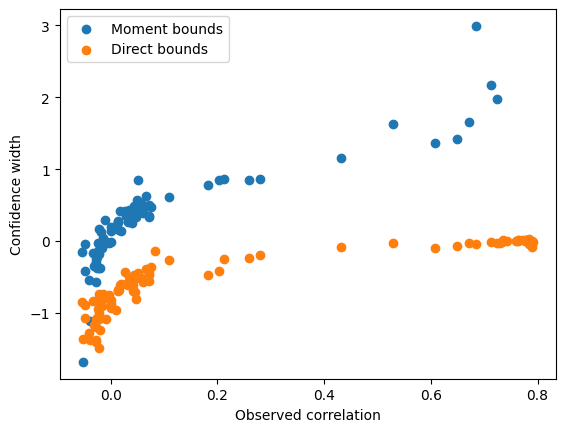

In [24]:
# observed correlation vs width
correlations_data = np.array([result['statistic'] for result in corr.result_dict.values()])
moment_width = np.log10(moment_bounds[1, :] - moment_bounds[0, :]) #- np.log10(correlations_data)
direct_width = np.log10(direct_bounds[1, :] - direct_bounds[0, :]) #- np.log10(correlations_data)
plt.scatter(correlations_data, moment_width, label="Moment bounds")
plt.scatter(correlations_data, direct_width, label="Direct bounds")
plt.xlabel("Observed correlation")
plt.ylabel("Confidence width")
plt.legend()
plt.show()

In [ ]:
# genes
genes = 100
k = 0
miRNA = "MIR100"

# settings
confidence = 0.95
d = 2

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_new = construct_dataset(data_new_miRNA.loc[miRNA], data_new_pcRNA[k:k+genes], beta_new)

# correlations
corr = Correlation(dataset_new, printing=False)

# bootstrap
dataset_new.confidence = confidence
dataset_new.bootstrap(d)

# moment bounds
moment_bounds = np.empty((2, genes))
for i in range(genes):
    moment_bounds[:, i] = moment_correlation_bounds(dataset.moment_bounds[f'sample-{i}'])

# direct bounds
direct_bounds = np.empty((2, genes))
for i in range(genes):
    direct_bounds[:, i] = direct_correlation_bootstrap(data_new_miRNA.loc[miRNA], data_new_pcRNA.iloc[i], confidence)

100%|██████████| 100/100 [00:00<00:00, 986.17it/s]
C:\Users\willi\AppData\Local\Temp\ipykernel_43000\2778741228.py:18: RuntimeWarning: invalid value encountered in sqrt
  correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))


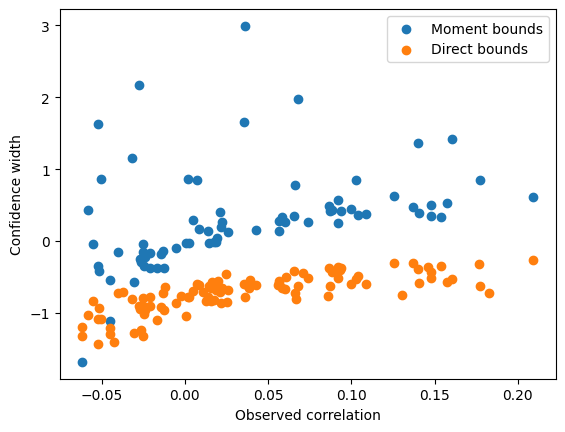

In [26]:
# observed correlation vs width
correlations_data = np.array([result['statistic'] for result in corr.result_dict.values()])
moment_width = np.log10(moment_bounds[1, :] - moment_bounds[0, :]) #- np.log10(correlations_data)
direct_width = np.log10(direct_bounds[1, :] - direct_bounds[0, :]) #- np.log10(correlations_data)
plt.scatter(correlations_data, moment_width, label="Moment bounds")
plt.scatter(correlations_data, direct_width, label="Direct bounds")
plt.xlabel("Observed correlation")
plt.ylabel("Confidence width")
plt.legend()
plt.show()

# Feasibility tests: results & recovered correlations

Run feasibility tests on (miRNA, mRNA) pairs and display results & recovered correlation values
- model free independence test (feasibility)
- model free interacting test (recovered correlation)
- interacting birth death feasibility test (both)
- interacting telegraph feasibility test (both)

In [17]:
def feasibility_test(dataset, d, confidence):

    # correlations
    corr = Correlation(dataset, printing=False)

    # bootstrap
    dataset.confidence = confidence
    dataset.bootstrap(d, tqdm_disable=False)

    # Independent model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=True
    )
    opt_MF_ind = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True)
    opt_MF_ind.analyse_dataset()

    # Interacting model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=False
    )
    opt_MF_int = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True)
    opt_MF_int.analyse_dataset()

    # Interacting birth death
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=False
    )
    fixed = [(1, 1)]
    opt_BD = optimization.BirthDeathOptimization(dataset, d, constraints=constraints, silent=True, fixed=fixed)
    opt_BD.analyse_dataset()

    # Interacting telegraph
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        telegraph_moments=True,
        telegraph_moments_ineq=True,
        telegraph_factorization=False
    )
    fixed = [(3, 1)]
    opt_TE = optimization.TelegraphOptimization(dataset, d, constraints=constraints, silent=True, fixed=fixed)
    opt_TE.analyse_dataset()

    # extract correlations
    correlations_TE = [solution['correlation'] for solution in opt_TE.result_dict.values()]
    correlations_BD = [solution['correlation'] for solution in opt_BD.result_dict.values()]
    correlations_MF = [solution['correlation'] for solution in opt_MF_int.result_dict.values()]
    correlations_data = [result['statistic'] for result in corr.result_dict.values()]

    # display
    name = ["MF (int)", "BD", "TE"]
    col = ["green", "orange", "blue"]
    for i, corrs in enumerate([correlations_MF, correlations_BD, correlations_TE]):
        plt.title("Correlation recovery")
        plt.xlabel("Observed Data Correlation")
        plt.ylabel("Recovered Feasible Correlation")
        plt.scatter(correlations_data, corrs, color=col[i], label=f"{name[i]} recovered correlation")
        plt.axline([-0.21, -0.21], [-0.2, -0.2], color="red", label="Equality")
        plt.legend()
        plt.show()

    # extract feasibility
    status_MF = [solution['status'] for solution in opt_MF_ind.result_dict.values()]
    status_BD = [solution['status'] for solution in opt_BD.result_dict.values()]
    status_TE = [solution['status'] for solution in opt_TE.result_dict.values()]

    # display MF (ind) feasibility vs observed correlation
    correlations_data_FMF = [rho for i, rho in enumerate(correlations_data) if status_MF[i] == "OPTIMAL"]
    correlations_data_IMF = [rho for i, rho in enumerate(correlations_data) if status_MF[i] == "INFEASIBLE"]
    plt.hist(correlations_data_FMF, bins=100, alpha=0.75, label="MF (ind) feasible")
    plt.hist(correlations_data_IMF, bins=100, alpha=0.75, label="MF (ind) infeasible")
    plt.xlabel("Observed Correlation")
    plt.legend()
    plt.show()

    # display BD feasibility vs observed correlation
    correlations_data_FBD = [rho for i, rho in enumerate(correlations_data) if status_BD[i] == "OPTIMAL"]
    correlations_data_IBD = [rho for i, rho in enumerate(correlations_data) if status_BD[i] == "INFEASIBLE"]
    plt.hist(correlations_data_FBD, bins=100, alpha=0.75, label="BD feasible")
    plt.hist(correlations_data_IBD, bins=100, alpha=0.75, label="BD infeasible")
    plt.xlabel("Observed Correlation")
    plt.legend()
    plt.show()

    # display TE feasibility vs observed correlation
    correlations_data_FTE = [rho for i, rho in enumerate(correlations_data) if status_TE[i] == "OPTIMAL"]
    correlations_data_ITE = [rho for i, rho in enumerate(correlations_data) if status_TE[i] == "INFEASIBLE"]
    plt.hist(correlations_data_FTE, bins=100, alpha=0.75, label="TE feasible")
    plt.hist(correlations_data_ITE, bins=100, alpha=0.75, label="TE infeasible")
    plt.xlabel("Observed Correlation")
    plt.legend()
    plt.show()

## Raw data

In [30]:
# genes
genes = 100
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc[miRNA], data_pcRNA[k:k+genes], beta)

100%|██████████| 100/100 [09:24<00:00,  5.64s/it]


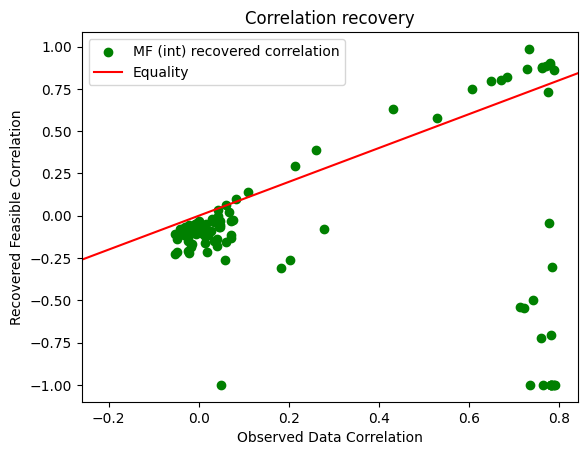

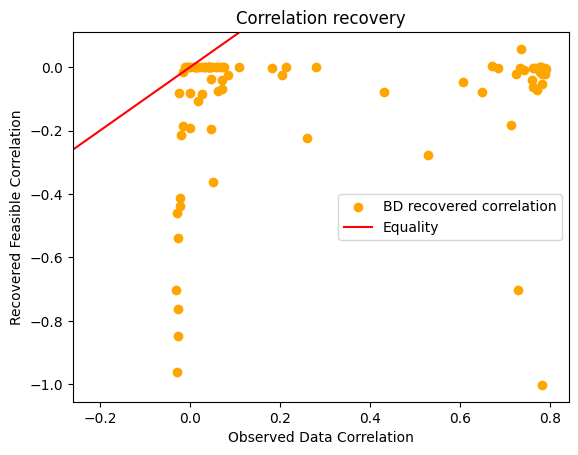

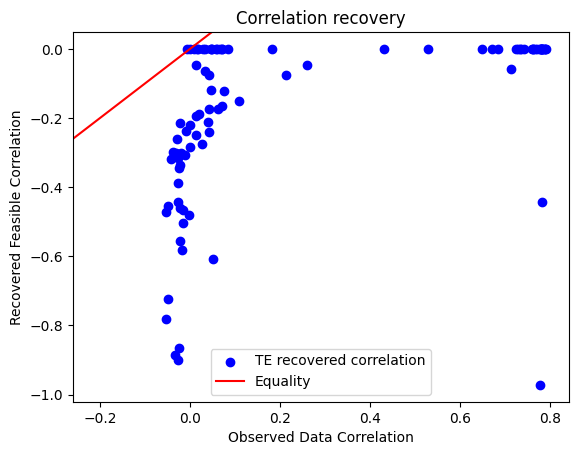

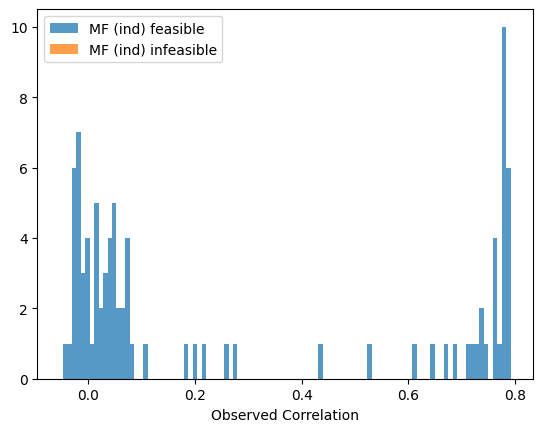

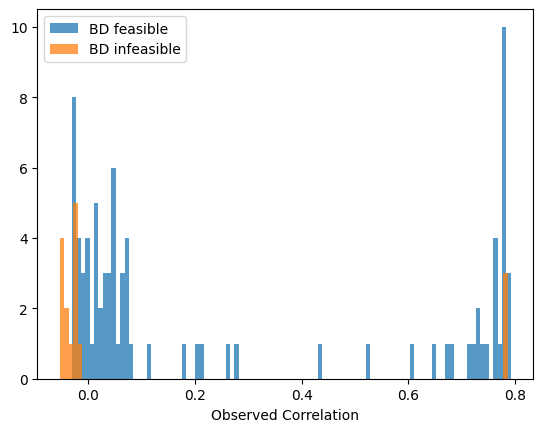

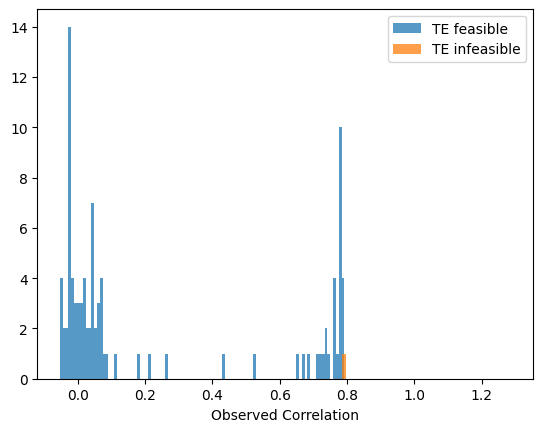

In [31]:
feasibility_test(dataset_mir, 3, 0.95)

## Outlier cell removed

In [ ]:
# genes
genes = 100
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_new = construct_dataset(data_new_miRNA.loc[miRNA], data_new_pcRNA[k:k+genes], beta_new) # re-run with beta_new

100%|██████████| 100/100 [03:48<00:00,  2.29s/it]


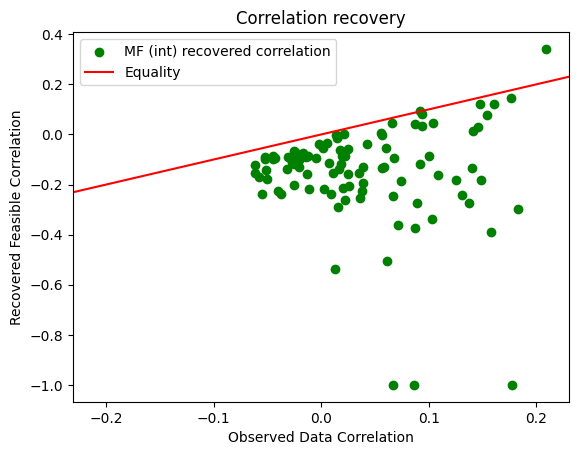

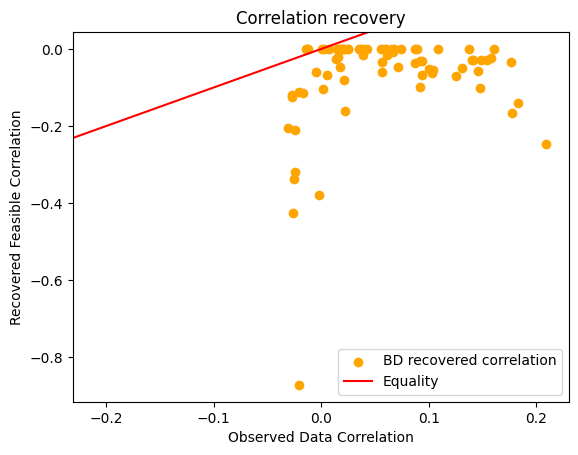

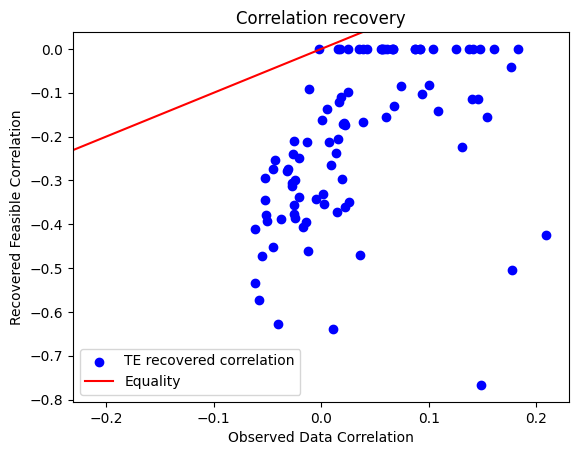

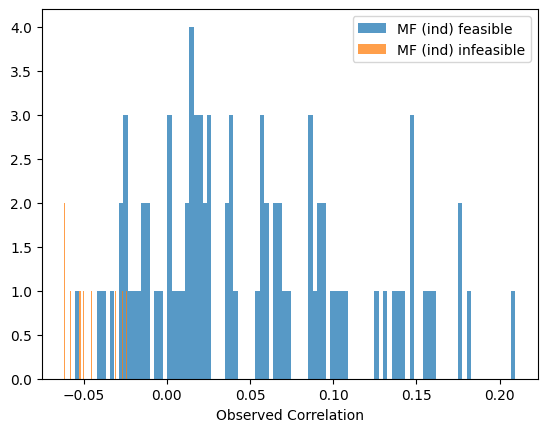

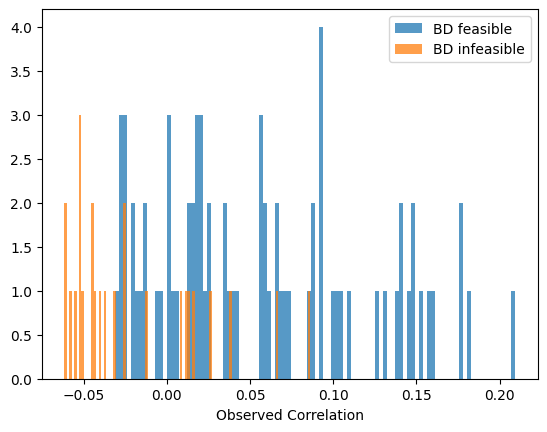

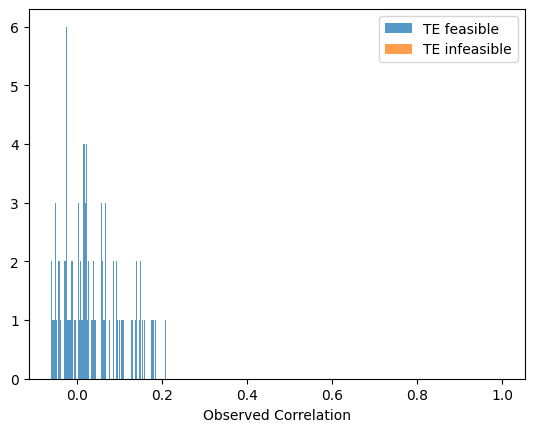

In [33]:
feasibility_test(dataset_new, 3, 0.95)

## Model free independence test focus

Focus on model free independence test, using higher moment order to see feasibility vs observed correlation

Want to understand which samples are found to be independent when adjusting for capture efficiency

In [18]:
def MF_test(dataset, d, confidence):

    # correlations
    corr = Correlation(dataset, printing=False)

    # bootstrap
    dataset.confidence = confidence
    dataset.bootstrap(d, tqdm_disable=False)

    # Independent model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=True
    )
    opt_MF_ind = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True)
    opt_MF_ind.analyse_dataset()

    # extract data correlations
    correlations_data = [result['statistic'] for result in corr.result_dict.values()]

    # extract feasibility
    status_MF = [solution['status'] for solution in opt_MF_ind.result_dict.values()]

    return status_MF, correlations_data

In [19]:
def MF_hist(status_MF, correlations_data):

    # display MF (ind) feasibility vs observed correlation
    correlations_data_FMF = [rho for i, rho in enumerate(correlations_data) if status_MF[i] == "OPTIMAL"]
    correlations_data_IMF = [rho for i, rho in enumerate(correlations_data) if status_MF[i] == "INFEASIBLE"]
    plt.hist(correlations_data_FMF, alpha=0.75, label="MF (ind) feasible")
    plt.hist(correlations_data_IMF, alpha=0.75, label="MF (ind) infeasible")
    plt.xlabel("Observed Correlation")
    plt.legend()
    plt.show()

### Raw data

In [64]:
# genes
genes = 1000
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset = construct_dataset(data_miRNA.loc[miRNA], data_pcRNA[k:k+genes], beta)

In [65]:
stat, corr = MF_test(dataset, 4, 0.95)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]


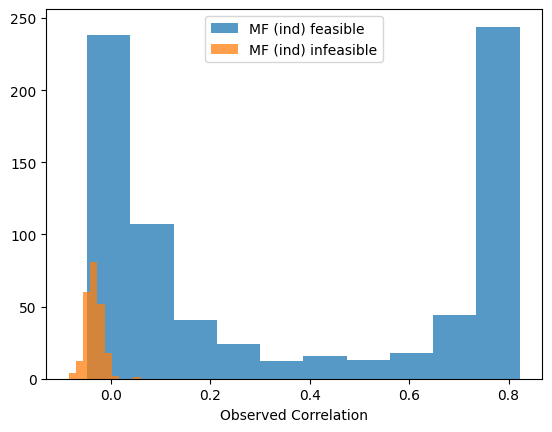

In [67]:
MF_hist(stat, corr)

### Outlier cell removed

In [100]:
# genes
genes = 1000
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_new = construct_dataset(data_new_miRNA.loc[miRNA], data_new_pcRNA[k:k+genes], beta_new)

In [101]:
stat, corr = MF_test(dataset_new, 4, 0.95)

100%|██████████| 1000/1000 [01:00<00:00, 16.61it/s]


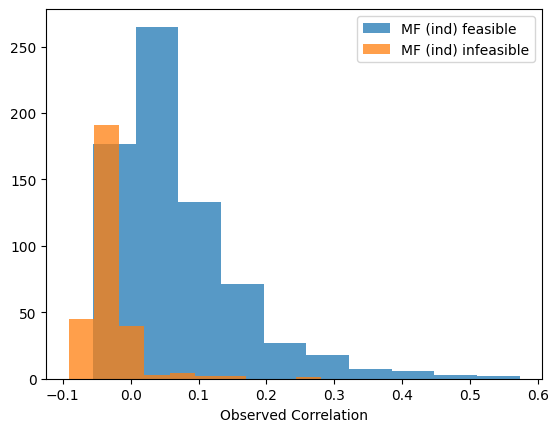

In [103]:
MF_hist(stat, corr)

Adjusting for downsampling should shift observed correlations to the left, giving lower original correlations

Mean capture efficiency set at 10% means this shift is quite strong

Feasible samples are those which are independent on the original scale, after adjusting for downsampling

Thus samples with lower observed correlation (around or to the left of zero) will be shifted to furthest away from 0 (negative) and so makes sense that these are infeasible

While samples with high observed correlation (to the right) will be shifted closer to 0 and so makes sense that these are feasible (could be independent)

__

Using the raw data the same pattern is observed, but harder to see as the outlying cell inflates correlations to large positive values that make the samples seem strongly correlated, when in reality they are not and this shouldbe reflected by the intervals on correlations which can include 0 despite a point estimate of 0.8

### Confidence effects

In [104]:
# genes
genes = 100
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_new = construct_dataset(data_new_miRNA.loc[miRNA], data_new_pcRNA[k:k+genes], beta_new)

100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


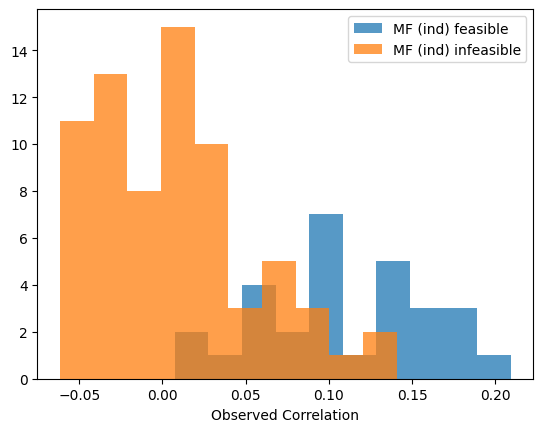

In [105]:
stat, corr = MF_test(dataset_new, 4, 0.5)
MF_hist(stat, corr)

100%|██████████| 100/100 [00:04<00:00, 20.97it/s]


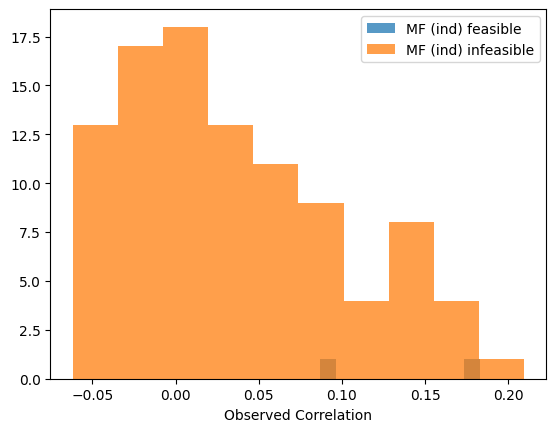

In [107]:
stat, corr = MF_test(dataset_new, 4, 0.25)
MF_hist(stat, corr)

### Moment order d effects

100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


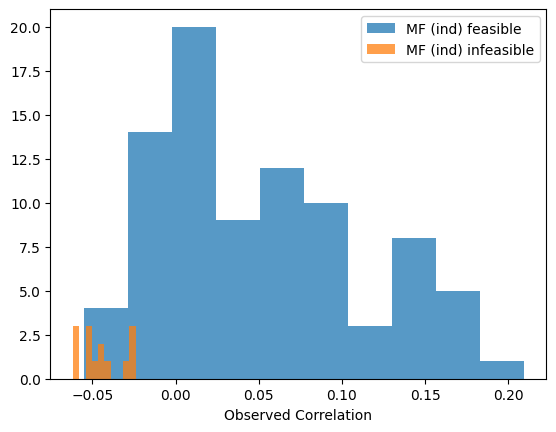

In [108]:
stat, corr = MF_test(dataset_new, 3, 0.95)
MF_hist(stat, corr)

100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


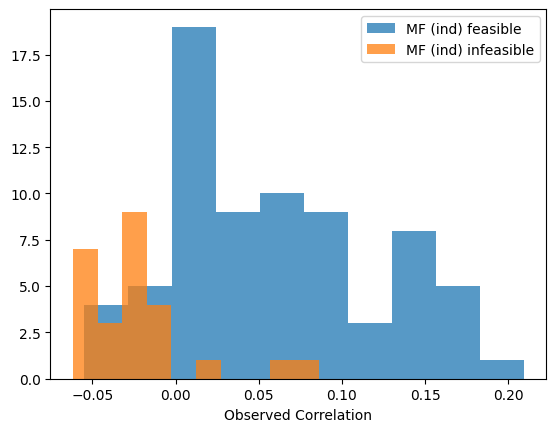

In [109]:
stat, corr = MF_test(dataset_new, 4, 0.95)
MF_hist(stat, corr)

100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


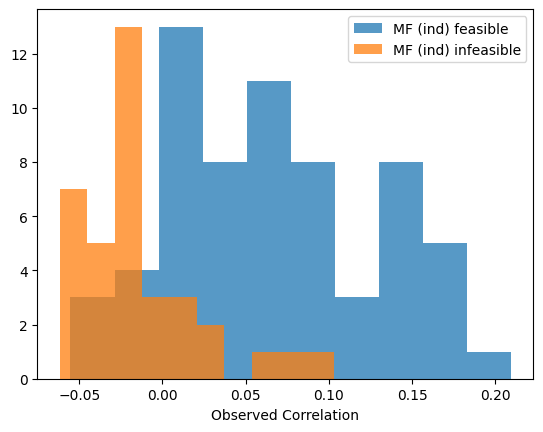

In [111]:
stat, corr = MF_test(dataset_new, 5, 0.95)
MF_hist(stat, corr)

### Confidence interval vs feasibility illustration

In [20]:
def MF_stack(status_MF, correlations_data, dataset, otype="moment", thresh=None, lw=1):

    # label flags
    bflag = True
    oflag = True

    # plot
    fig, ax = plt.subplots()

    # display samples observed correlation ranges coloured by MF (ind) feasibility
    for i, status in enumerate(status_MF):
        
        # point correlation value
        rho = correlations_data[i]

        # colour
        if status == "OPTIMAL":
            col = "blue"
        elif status == "INFEASIBLE":
            col = "orange"

        # label
        if bflag and col == "blue":
            label="Feasible (MF ind)"
            bflag=False
        elif oflag and col == "orange":
            label="Infeasible (MF ind)"
            oflag = False
        else:
            label=None

        # moment bounds on observed correlation
        if otype == "moment":
            moment_bounds = dataset.moment_bounds[f'sample-{i}']
            lb, ub = moment_correlation_bounds(moment_bounds)

        # direct bounds on observed correlation
        elif otype == "direct":
            sample = dataset.count_dataset.loc[f'Gene-pair-{i}']
            x1_sample = [x[0] for x in sample]
            x2_sample = [x[1] for x in sample]
            lb, ub = direct_correlation_bootstrap(x1_sample, x2_sample)

        # thresh
        if thresh:
            if ub > thresh:
                ub = thresh

        plt.plot([lb, ub], [i, i], color=col, linewidth=lw, label=label)
        plt.plot([rho, rho], [i - 0.1, i + 0.1], color=col, linewidth=2*lw)
    
    plt.title("Observed correlation intervals: independent feasibility")
    plt.xlabel("Observed correlation")
    plt.ylabel("Sample index")
    plt.legend()
    plt.show()

In [112]:
# genes
genes = 20
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset = construct_dataset(data_miRNA.loc[miRNA], data_pcRNA[k:k+genes], beta)

In [113]:
stat, corr = MF_test(dataset, 4, 0.95)

100%|██████████| 20/20 [00:01<00:00, 11.50it/s]


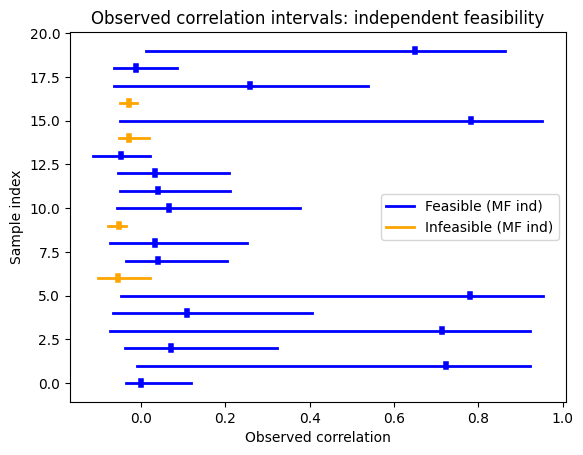

In [144]:
MF_stack(stat, corr, dataset, otype="direct", lw=2)

In [145]:
# genes
genes = 20
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_new = construct_dataset(data_new_miRNA.loc[miRNA], data_new_pcRNA[k:k+genes], beta_new)

In [146]:
stat_new, corr_new = MF_test(dataset_new, 4, 0.95)

100%|██████████| 20/20 [00:01<00:00, 14.96it/s]


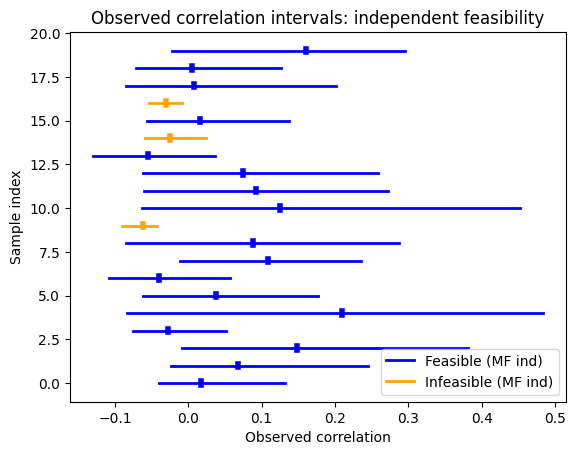

In [147]:
MF_stack(stat_new, corr_new, dataset_new, otype="direct", lw=2)

# Single sample: detailed feasibility & recovered correlations

## High correlation, independent sample

Pair (MIR100, CDPF1) has a high positive observed correlation, but is feasible under model free independence test (MF ind)

Investigate feasibility results & recovered correlations

### Sample

pair 338 (MIR100, CDPF1) has correlation 0.41099327234621064

Moment bootstrap correlation bounds (-0.029472848817946668, nan)
Direct bootstrap correlation bounds (-0.062302914750160095, 0.8452672417688103)

pair 338 (MIR100, CDPF1) has correlation 0.6710695745740006 when outlier cell removed

Moment bootstrap correlation bounds (-0.035703375623439546, nan)
Direct bootstrap correlation bounds (-0.06815775292680196, 0.9043996612607023)


C:\Users\willi\AppData\Local\Temp\ipykernel_40768\2778741228.py:18: RuntimeWarning: invalid value encountered in sqrt
  correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))
C:\Users\willi\AppData\Local\Temp\ipykernel_40768\2778741228.py:18: RuntimeWarning: invalid value encountered in sqrt
  correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))


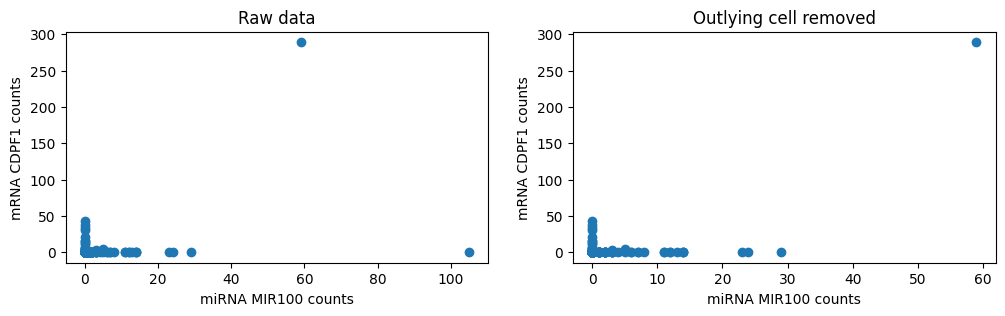

In [21]:
# select pair
miRNA = 'MIR100'
mRNA = 'CDPF1'

# settings
confidence = 0.95
d = 6

# get sample
sample_mRNA = data_pcRNA.loc[mRNA]
sample_miRNA = data_miRNA.loc[miRNA] 
corr = scipy.stats.pearsonr(sample_miRNA, sample_mRNA).statistic
print(f"pair {idx} ({miRNA}, {mRNA}) has correlation {corr}\n")

# bootstrap correlation
dataset_sample = construct_sample_dataset(sample_miRNA, sample_mRNA, beta)
dataset_sample.confidence = confidence
dataset_sample.bootstrap(d)
moment_lb, moment_ub = moment_correlation_bounds(dataset_sample.moment_bounds['sample-0'])
direct_lb, direct_ub = direct_correlation_bootstrap(sample_miRNA, sample_mRNA, confidence)
print(f"Moment bootstrap correlation bounds ({moment_lb}, {moment_ub})")
print(f"Direct bootstrap correlation bounds ({direct_lb}, {direct_ub})")

# get same sample but outlier removed
sample_new_mRNA = data_new_pcRNA.loc[mRNA]
sample_new_miRNA = data_new_miRNA.loc[miRNA] 
corr_new = scipy.stats.pearsonr(sample_new_miRNA, sample_new_mRNA).statistic
print(f"\npair {idx} ({miRNA}, {mRNA}) has correlation {corr_new} when outlier cell removed\n")

# bootstrap correlation
dataset_new_sample = construct_sample_dataset(sample_new_miRNA, sample_new_mRNA, beta_new)
dataset_new_sample.confidence = confidence
dataset_new_sample.bootstrap(d)
moment_new_lb, moment_new_ub = moment_correlation_bounds(dataset_new_sample.moment_bounds['sample-0'])
direct_new_lb, direct_new_ub = direct_correlation_bootstrap(sample_new_miRNA, sample_new_mRNA, confidence)
print(f"Moment bootstrap correlation bounds ({moment_new_lb}, {moment_new_ub})")
print(f"Direct bootstrap correlation bounds ({direct_new_lb}, {direct_new_ub})")

# display
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].scatter(sample_miRNA, sample_mRNA)
axs[0].set_title("Raw data")
axs[0].set_ylabel(f"mRNA {mRNA} counts")
axs[0].set_xlabel(f"miRNA {miRNA} counts")
axs[1].scatter(sample_new_miRNA, sample_new_mRNA)
axs[1].set_title("Outlying cell removed")
axs[1].set_ylabel(f"mRNA {mRNA} counts")
axs[1].set_xlabel(f"miRNA {miRNA} counts")
plt.show()

In [134]:
# collect observed correlation ranges
observed_correlations = {
    'OB': corr_new,
    'OB_range_moment': [moment_new_lb, moment_new_ub],
    'OB_range_direct': [direct_new_lb, direct_new_ub]
}

### Feasibility

In [22]:
def print_feasibility(opt, name):
    res = opt.result_dict[0]
    print(f"{name} {res['status']}")
    print(f"\nCuts {res['cuts']} Time {res['time']} Recovered correlation {res['correlation']}\n")

In [23]:
def sample_feasibility(dataset, d_MF, d_BD, d_TE):

    # Independent model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=True
    )
    opt_MF_ind = optimization.ModelFreeOptimization(dataset, d_MF, constraints=constraints, printing=False, silent=True)
    opt_MF_ind.analyse_dataset()

    # Interacting model free
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=False
    )
    opt_MF_int = optimization.ModelFreeOptimization(dataset, d_MF, constraints=constraints, printing=False, silent=True)
    opt_MF_int.analyse_dataset()

    # Interacting birth death
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=False
    )
    fixed = [(1, 1)]
    opt_BD = optimization.BirthDeathOptimization(dataset, d_BD, constraints=constraints, silent=True, fixed=fixed)
    opt_BD.analyse_dataset()

    # Interacting telegraph
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        telegraph_moments=True,
        telegraph_moments_ineq=True,
        telegraph_factorization=False
    )
    fixed = [(3, 1)]
    opt_TE = optimization.TelegraphOptimization(dataset, d_TE, constraints=constraints, silent=True, fixed=fixed)
    opt_TE.analyse_dataset()

    # display results
    print_feasibility(opt_MF_ind, "Independent Model Free")
    print_feasibility(opt_MF_int, "Interacting Model Free")
    print_feasibility(opt_BD, "Interacting Birth Death")
    print_feasibility(opt_TE, "Interacting Telegraph")

In [24]:
sample_feasibility(dataset_new_sample, d_MF=4, d_BD=3, d_TE=3)

100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

Independent Model Free OPTIMAL

Cuts 4 Time 0.10799980163574219 Recovered correlation 2.5483322650218345e-16

Interacting Model Free OPTIMAL

Cuts 10 Time 0.0009999275207519531 Recovered correlation -1.0000000695049898

Interacting Birth Death OPTIMAL

Cuts 4 Time 0.04399991035461426 Recovered correlation -0.016547099555545158

Interacting Telegraph OPTIMAL

Cuts 5 Time 0.04999995231628418 Recovered correlation -0.14982653843807134



### Recovered correlation

In [164]:
def sample_recovered_correlations(dataset, rho_range, d_MF, d_BD, d_TE):

    # collect
    recovered_correlations = {}

    # Interacting model free
    if d_MF:
        constraints = Constraint(
            moment_bounds=True,
            moment_matrices=True,
            factorization=False
        )
        opt_MF_int = optimization.ModelFreeOptimization(dataset, d_MF, constraints=constraints, printing=False, silent=True)
        opt_MF_int.analyse_dataset()

        # extract point recovered correlation
        recovered_correlation_MF = opt_MF_int.result_dict[0]['correlation']
        recovered_correlation_range_MF = []

        # if feasible
        if opt_MF_int.result_dict[0]['status'] == "OPTIMAL":

            # test feasibility over range of fixed correlation values
            for rho in tqdm.tqdm(rho_range):
                fixed_correlation = rho
                opt_MF_rho = optimization.ModelFreeOptimization(dataset, d_MF, constraints=constraints, silent=True, fixed_correlation=fixed_correlation, tqdm_disable=True)
                opt_MF_rho.analyse_dataset()
                if opt_MF_rho.result_dict[0]['status'] == "OPTIMAL":
                    recovered_correlation_range_MF.append(rho)

        recovered_correlations['MF'] = recovered_correlation_MF
        recovered_correlations['MF_range'] = recovered_correlation_range_MF
        
    if d_BD:
        # Interacting birth death
        constraints = Constraint(
            moment_bounds=True,
            moment_matrices=True,
            moment_equations=True,
            factorization=False
        )
        fixed = [(1, 1)]
        opt_BD = optimization.BirthDeathOptimization(dataset, d_BD, constraints=constraints, silent=True, fixed=fixed)
        opt_BD.analyse_dataset()

        # extract point recovered correlation
        recovered_correlation_BD = opt_BD.result_dict[0]['correlation']
        recovered_correlation_range_BD = []

        # if feasible
        if opt_BD.result_dict[0]['status'] == "OPTIMAL":

            # test feasibility over range of fixed correlation values
            for rho in tqdm.tqdm(rho_range):
                fixed_correlation = rho
                opt_BD_rho = optimization.BirthDeathOptimization(dataset, d_BD, constraints=constraints, silent=True, fixed=fixed, fixed_correlation=fixed_correlation, tqdm_disable=True)
                opt_BD_rho.analyse_dataset()
                if opt_BD_rho.result_dict[0]['status'] == "OPTIMAL":
                    recovered_correlation_range_BD.append(rho)

        recovered_correlations['BD'] = recovered_correlation_BD
        recovered_correlations['BD_range'] = recovered_correlation_range_BD

    if d_TE:
        # Interacting telegraph
        constraints = Constraint(
            moment_bounds=True,
            moment_matrices=True,
            moment_equations=True,
            telegraph_moments=True,
            telegraph_moments_ineq=True,
            telegraph_factorization=False
        )
        fixed = [(3, 1)]
        opt_TE = optimization.TelegraphOptimization(dataset, d_TE, constraints=constraints, silent=True, fixed=fixed)
        opt_TE.analyse_dataset()

        # extract point recovered correlation
        recovered_correlation_TE = opt_TE.result_dict[0]['correlation']
        recovered_correlation_range_TE = []

        # if feasible
        if opt_TE.result_dict[0]['status'] == "OPTIMAL":

            # test feasibility over range of fixed correlation values
            for rho in tqdm.tqdm(rho_range):
                fixed_correlation = rho
                opt_TE_rho = optimization.TelegraphOptimization(dataset, d_TE, constraints=constraints, silent=True, fixed=fixed, fixed_correlation=fixed_correlation, tqdm_disable=True)
                opt_TE_rho.analyse_dataset()
                if opt_TE_rho.result_dict[0]['status'] == "OPTIMAL":
                    recovered_correlation_range_TE.append(rho)

        recovered_correlations['TE'] = recovered_correlation_TE
        recovered_correlations['TE_range'] = recovered_correlation_range_TE

    return recovered_correlations

In [225]:
rho_range = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]

In [226]:
recovered_correlations = sample_recovered_correlations(dataset_new_sample, rho_range=rho_range, d_MF=4, d_BD=3, d_TE=3)

 89%|████████▉ | 8/9 [00:07<00:01,  1.12s/it]c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\SDP_interaction_inference\optimization_utils.py:606: RuntimeWarning: invalid value encountered in sqrt
  correlation = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))
100%|██████████| 9/9 [17:05<00:00, 113.91s/it]


In [242]:
def plot_funnel(recovered_correlations, observed_correlations, rtypes=[], otype="moment", thresh=1, lw=1):

    # type of observed correlation range
    if otype == "moment":
        OB_range = deepcopy(observed_correlations['OB_range_moment'])
    elif otype == "direct":
        OB_range = deepcopy(observed_correlations['OB_range_direct'])
    
    # threshold
    if np.isnan(OB_range[1]) or OB_range[1] > thresh:
        OB_range[1] = thresh

    y = 0

    fig = plt.figure(figsize=(10, 2))
    plt.plot(OB_range, [y, y], color="purple", linewidth=lw, label=f"Observed correlation ({otype})")
    plt.plot([observed_correlations['OB'], observed_correlations['OB']], [y + 0.1, y - 0.1], color="purple", linewidth=2*lw)

    for rtype in rtypes:

        y -= 1

        if rtype == "MF": col = "orange"
        if rtype == "BD": col = "blue"
        if rtype == "TE": col = "green"

        # type of recovered correlation range
        R_range = recovered_correlations[f'{rtype}_range']

        # plt.scatter(R_range, [0 for x in R_range], color="orange", s=10*lw, label=f"Recovered correlation ({rtype})")
        plt.plot([R_range[0], R_range[-1]], [y, y], color=col, linewidth=lw, label=f"Recovered correlation ({rtype})")
        plt.plot([recovered_correlations[rtype], recovered_correlations[rtype]], [y - 0.1, y + 0.1], color=col, linewidth=2*lw)

    plt.title("Feasible Correlations: observed & recovered")
    plt.xlabel("Correlation")
    plt.legend()
    plt.show()

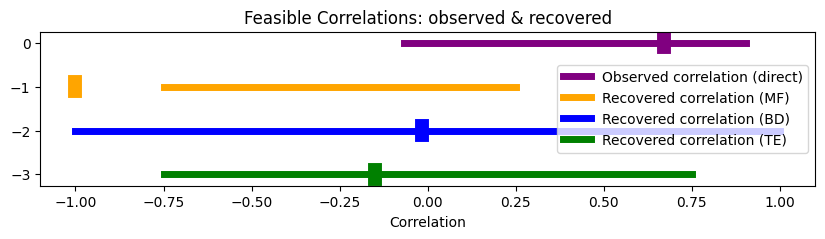

In [243]:
plot_funnel(recovered_correlations, observed_correlations, ["MF", "BD", "TE"], "direct", lw=5, thresh=2)

In [249]:
def plot_rectangle(recovered_correlations, observed_correlations, rtypes=[], otype="direct", lw=1, thresh=1):
    
    # type of observed correlation range
    if otype == "moment":
        OB_range = deepcopy(observed_correlations['OB_range_moment'])
    elif otype == "direct":
        OB_range = deepcopy(observed_correlations['OB_range_direct'])

    # threshold
    if np.isnan(OB_range[1]) or OB_range[1] > thresh:
        OB_range[1] = thresh

    
    fig, axs = plt.subplots()

    for rtype in rtypes:

        if rtype == "MF": col = "orange"
        if rtype == "BD": col = "blue"
        if rtype == "TE": col = "green"

        # recovered correlation range
        R_range = recovered_correlations[f'{rtype}_range']

        box = matplotlib.patches.Rectangle((OB_range[0], R_range[0]), np.abs(OB_range[1] - OB_range[0]), np.abs(R_range[-1] - R_range[0]), color=col)
        box.set_alpha(0.5)
        axs.add_patch(box)
        axs.scatter(observed_correlations['OB'], recovered_correlations[rtype], s=10*lw, color=col, label=f"Recovered correlation ({rtype})")

    axs.set_xlabel("Observed correlation")
    axs.set_ylabel("Recovered correlation")
    plt.legend()
    plt.show()

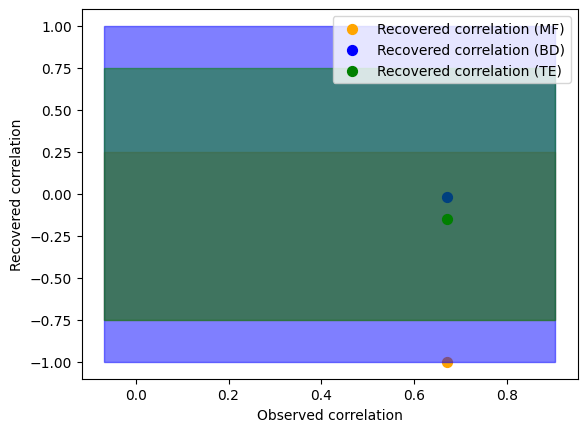

In [251]:
plot_rectangle(recovered_correlations, observed_correlations, ["MF", "BD", "TE"], "direct", lw=5, thresh=1)

### Numerical issues

Fixing correlation through constraints tricky as optimization in terms of moments, which have complicated relationship to correlation

rho**2 * var_x * var_y - cov_xy = 0 used to fix correlation equal to rho (along with sign of cov_xy)

BUT this is satisfied for values of e.g. 10**-7

This is not close enough to 0 to be accurate, as rearranging for correlation is very far from the set value of rho e.g. 10**-5 vs 0.4 set

OR may be satisfied by being genuinely 0 / close to 0 e.g. 10**-12

BUT with cov / a var equal to 0 / close to 0 (perhaps slightly negative), so rearranging for correlation is undefined

___

Overall correlation tricky as optimization only based on moments, correlation not really a 'thing' inside

In [216]:
# Interacting birth death
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    factorization=False
)
fixed = [(1, 1)]
rho = 1.0
opt_BD = optimization.BirthDeathOptimization(dataset_new_sample, 3, constraints=constraints, silent=True, fixed=fixed, fixed_correlation=rho, tqdm_disable=True, write_model=True)
opt_BD.analyse_dataset()

c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\SDP_interaction_inference\optimization_utils.py:606: RuntimeWarning: invalid value encountered in sqrt
  correlation = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))


In [218]:
opt_BD.result_dict

{0: {'status': 'OPTIMAL',
  'time': 39.64200019836426,
  'cuts': 39,
  'correlation': np.float64(nan)}}

In [219]:
y = opt_BD.feasible_values_dict[0][-1]
y

{'y[0]': 1.0,
 'y[1]': 18.58548005754696,
 'y[2]': 26.781056745483845,
 'y[3]': 364.00554902702265,
 'y[4]': 497.7387960632235,
 'y[5]': 717.2250004048256,
 'y[6]': 746652.9815041191,
 'y[7]': 9250.714408827153,
 'y[8]': 13330.305946536066,
 'y[9]': 75685767.95094097,
 'k[0]': 18.58548005754696,
 'k[1]': 1.0,
 'k[2]': 0.0,
 'k[3]': 0.0,
 'k[4]': 0.0,
 'C15': 0.0}

In [220]:
powers = utils.compute_powers(S=2, d=3)
i_xy = powers.index([1, 1])
i_x  = powers.index([1, 0])
i_y  = powers.index([0, 1])
i_x2 = powers.index([2, 0])
i_y2 = powers.index([0, 2])

# collect moment values
E_xy = y[f'y[{i_xy}]']
E_x  = y[f'y[{i_x}]']
E_y  = y[f'y[{i_y}]']
E_x2 = y[f'y[{i_x2}]']
E_y2 = y[f'y[{i_y2}]']

# compute correlation
rho_feas = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))
rho_feas

C:\Users\willi\AppData\Local\Temp\ipykernel_40768\245550628.py:16: RuntimeWarning: invalid value encountered in sqrt
  rho_feas = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))


np.float64(nan)

In [222]:
cov_xy = E_xy - E_x * E_y
var_x = E_x2 - E_x**2
var_y = E_y2 - E_y**2
cov_xy, var_x, var_y

(0.0, 18.58548005754693, -2.2737367544323206e-13)

In [223]:
rho**2 * var_x * var_y - cov_xy**2

-4.225848910561338e-12

In [224]:
cov_xy / np.sqrt(var_x * var_y)

C:\Users\willi\AppData\Local\Temp\ipykernel_40768\3703204565.py:1: RuntimeWarning: invalid value encountered in sqrt
  cov_xy / np.sqrt(var_x * var_y)


np.float64(nan)

## Low correlation, dependent sample

Pair (MIR100, CISD1) has a small negative observed correlation, and is infeasible under model free independence test (MF ind)

Investigate feasibility results & recovered correlations

### Sample

pair 338 (MIR100, CISD1) has correlation 0.7110154483673885

Moment bootstrap correlation bounds (-0.053487115401654614, nan)
Direct bootstrap correlation bounds (-0.16213253726862817, 0.9408515372597828)

pair 338 (MIR100, CISD1) has correlation -0.1131634542839691 when outlier cell removed

Moment bootstrap correlation bounds (-0.16720701755203915, 0.29343676694859855)
Direct bootstrap correlation bounds (-0.1669614629678122, -0.05851793804020019)


C:\Users\willi\AppData\Local\Temp\ipykernel_40768\2778741228.py:18: RuntimeWarning: invalid value encountered in sqrt
  correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))


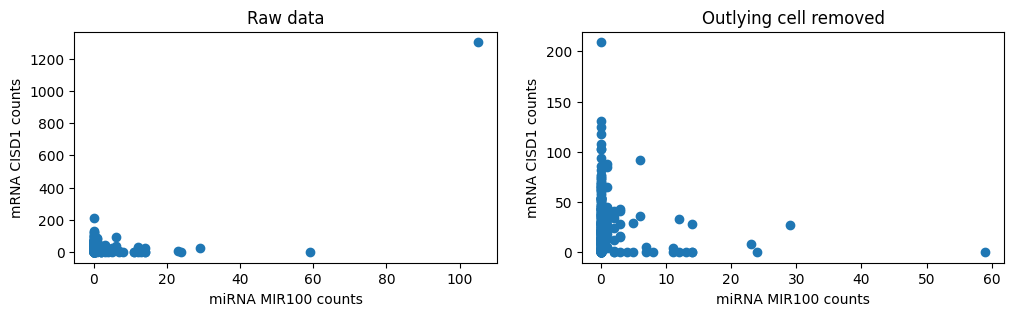

In [252]:
# select pair
miRNA = 'MIR100'
mRNA = 'CISD1'

# settings
confidence = 0.95
d = 6

# get sample
sample_mRNA = data_pcRNA.loc[mRNA]
sample_miRNA = data_miRNA.loc[miRNA] 
corr = scipy.stats.pearsonr(sample_miRNA, sample_mRNA).statistic
print(f"pair {idx} ({miRNA}, {mRNA}) has correlation {corr}\n")

# bootstrap correlation
dataset_sample = construct_sample_dataset(sample_miRNA, sample_mRNA, beta)
dataset_sample.confidence = confidence
dataset_sample.bootstrap(d)
moment_lb, moment_ub = moment_correlation_bounds(dataset_sample.moment_bounds['sample-0'])
direct_lb, direct_ub = direct_correlation_bootstrap(sample_miRNA, sample_mRNA, confidence)
print(f"Moment bootstrap correlation bounds ({moment_lb}, {moment_ub})")
print(f"Direct bootstrap correlation bounds ({direct_lb}, {direct_ub})")

# get same sample but outlier removed
sample_new_mRNA = data_new_pcRNA.loc[mRNA]
sample_new_miRNA = data_new_miRNA.loc[miRNA] 
corr_new = scipy.stats.pearsonr(sample_new_miRNA, sample_new_mRNA).statistic
print(f"\npair {idx} ({miRNA}, {mRNA}) has correlation {corr_new} when outlier cell removed\n")

# bootstrap correlation
dataset_new_sample = construct_sample_dataset(sample_new_miRNA, sample_new_mRNA, beta_new)
dataset_new_sample.confidence = confidence
dataset_new_sample.bootstrap(d)
moment_new_lb, moment_new_ub = moment_correlation_bounds(dataset_new_sample.moment_bounds['sample-0'])
direct_new_lb, direct_new_ub = direct_correlation_bootstrap(sample_new_miRNA, sample_new_mRNA, confidence)
print(f"Moment bootstrap correlation bounds ({moment_new_lb}, {moment_new_ub})")
print(f"Direct bootstrap correlation bounds ({direct_new_lb}, {direct_new_ub})")

# display
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].scatter(sample_miRNA, sample_mRNA)
axs[0].set_title("Raw data")
axs[0].set_ylabel(f"mRNA {mRNA} counts")
axs[0].set_xlabel(f"miRNA {miRNA} counts")
axs[1].scatter(sample_new_miRNA, sample_new_mRNA)
axs[1].set_title("Outlying cell removed")
axs[1].set_ylabel(f"mRNA {mRNA} counts")
axs[1].set_xlabel(f"miRNA {miRNA} counts")
plt.show()

In [253]:
# collect observed correlation ranges
observed_correlations = {
    'OB': corr_new,
    'OB_range_moment': [moment_new_lb, moment_new_ub],
    'OB_range_direct': [direct_new_lb, direct_new_ub]
}

### Feasibility

In [254]:
sample_feasibility(dataset_new_sample, d_MF=4, d_BD=3, d_TE=3)

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

Independent Model Free INFEASIBLE

Cuts 0 Time 0.009000062942504883 Recovered correlation None

Interacting Model Free OPTIMAL

Cuts 19 Time 0.015000343322753906 Recovered correlation -0.96842209772155

Interacting Birth Death INFEASIBLE

Cuts 0 Time 0.08599996566772461 Recovered correlation None

Interacting Telegraph OPTIMAL

Cuts 5 Time 0.26600027084350586 Recovered correlation -0.7563013205104898



### Recovered correlation

In [ ]:
rho_range = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]

In [255]:
recovered_correlations = sample_recovered_correlations(dataset_new_sample, rho_range=rho_range, d_MF=4, d_BD=3, d_TE=3)

100%|██████████| 9/9 [02:02<00:00, 13.66s/it] 


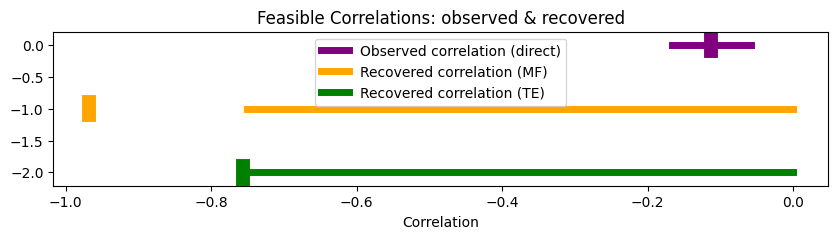

In [258]:
plot_funnel(recovered_correlations, observed_correlations, ["MF", "TE"], "direct", lw=5, thresh=2)

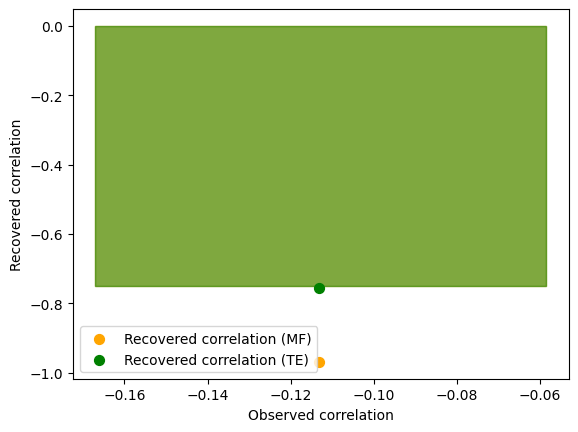

In [259]:
plot_rectangle(recovered_correlations, observed_correlations, ["MF", "TE"], "direct", lw=5, thresh=1)

# Old

In [104]:
# Q: moment bounds not not directly restrict correlation to below 1, do semidefinite constraints ensure this?
# seems to be enforced by moment matrices (semidefinite constriants)
# testing feasibility of recovered correlations outside [-1, 1] only feasible when no moment matrices
# BUT this only means original correlation constrained, not the observed correlation which can be outside [-1, 1] using bounds

Results quite variable when re-bootstrapping
- Int BD can switch between feasible and infeasible
- recovered correlation range (when feasible) either very small i.e [-0.1, 0], or very wide i.e [-1, 0]

Recovered correlation tightens from [-1, 1] to [-0.8, 0] when d = 3 -> 4

# Todo

Note what is done so far

Change structure
- observed correlations
    - hist & scatter for all mRNA
    - individual sample
    - show outliers
    - effect of removal on individual sample correlation
    - effect of removal on all mRNA scatter structure
        - show effects on other miRNA (bimodal is just artifact?)
- feasibility tests
    - hist of observed correlations categorised by result
    - scatter of recovered correlations
    - effect of outlier removal
    - effect of confidence

- Investigate individual sample further (maybe in above sections)
    - observed correlation & bootstrap widths
    - recovered correlation & width (using rejection optimization idea)
    

# Data Correlation Investigation

Investigate model results and feasible recovered correlations compared to observed correlations in data

In [468]:
# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../../Real-Data/Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

# read RNA types in from file
biotypes_dict = json.load(open("../../Real-Data/Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# select rows by index
data_pcRNA = data_FIB.iloc[pcRNA_indices]
data_miRNA = data_FIB.iloc[miRNA_indices]

# amounts
print(f"{data_FIB.shape[0]} genes with mean > 1 \n{data_miRNA.shape[0]} miRNA \n{data_pcRNA.shape[0]} protein coding mRNA")

11901 genes with mean > 1 
18 miRNA 
9376 protein coding mRNA


In [3]:
def estimate_capture(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

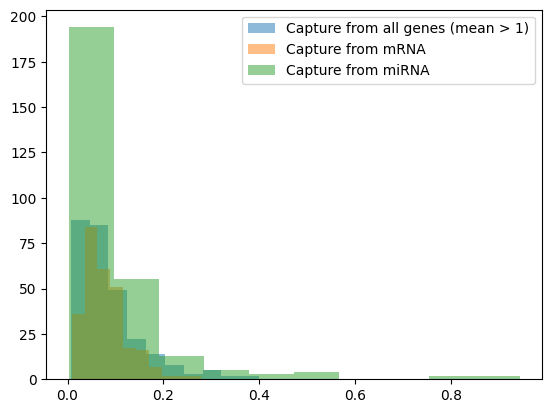

In [4]:
beta = estimate_capture(data_FIB)
beta_m = estimate_capture(data_pcRNA)
beta_mi = estimate_capture(data_miRNA)
plt.hist(beta, alpha=0.5, label="Capture from all genes (mean > 1)")
plt.hist(beta_m, alpha=0.5, label="Capture from mRNA")
plt.hist(beta_mi, alpha=0.5, label="Capture from miRNA")
plt.legend()
plt.show()

In [5]:
def construct_dataset(mirna_sample, mrna_dataset, beta, resamples=1000):

    # size
    gene_pairs, cells = mrna_dataset.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mirna_sample
        gene_j = mrna_dataset.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

# Feasibility results vs Observed correlations

(miRNA, mRNA) for single miRNA and and many mRNA, plot feasibility result categories against observed correlations (bimodal)
- model free independence test
- interacting birth-death test
- interacting telegraph test

Also look at recovered correlation values for tests

In [88]:
# genes
genes = 100
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc[miRNA], data_pcRNA[k:k+genes], beta)

In [89]:
# correlations
corr = Correlation(dataset_mir, printing=False)

100%|██████████| 100/100 [00:00<00:00, 521.26it/s]


In [90]:
# bootstrap
d = 4
dataset_mir.confidence = 0.05
dataset_mir.bootstrap(d, tqdm_disable=False)

100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


In [91]:
#settings
d = 3
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=False
)

# test feasibility
opt_MF = optimization.ModelFreeOptimization(dataset_mir, d, constraints=constraints, printing=False, silent=True)
opt_MF.analyse_dataset()

100%|██████████| 100/100 [00:04<00:00, 21.41it/s]


In [92]:
#settings
d = 3
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    factorization=False
)
fixed = [(1, 1)]

# test feasibility
opt_BD = optimization.BirthDeathOptimization(dataset_mir, d, constraints=constraints, silent=True, fixed=fixed)
opt_BD.analyse_dataset()

  0%|          | 0/100 [00:00<?, ?it/s]

 64%|██████▍   | 64/100 [00:12<00:06,  6.00it/s]c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\SDP_interaction_inference\optimization_utils.py:606: RuntimeWarning: invalid value encountered in sqrt
  correlation = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))
100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


In [93]:
#settings
d = 3
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    telegraph_moments=True,
    telegraph_moments_ineq=True,
    telegraph_factorization=False
)
fixed = [(3, 1)]

# test feasibility
opt_TE = optimization.TelegraphOptimization(dataset_mir, d, constraints=constraints, silent=True, fixed=fixed)
opt_TE.analyse_dataset()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [09:20<00:00,  5.61s/it]


## Recovered correlations

In [94]:
# extract correlations
correlations_TE = [solution['correlation'] for solution in opt_TE.result_dict.values()]
correlations_BD = [solution['correlation'] for solution in opt_BD.result_dict.values()]
correlations_MF = [solution['correlation'] for solution in opt_MF.result_dict.values()]
correlations_data = [result['statistic'] for result in corr.result_dict.values()]

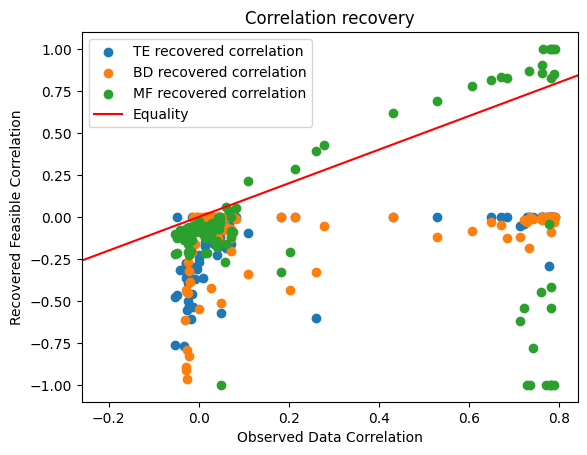

In [95]:
# display
plt.title("Correlation recovery")
plt.xlabel("Observed Data Correlation")
plt.ylabel("Recovered Feasible Correlation")
plt.scatter(correlations_data, correlations_TE, label="TE recovered correlation")
plt.scatter(correlations_data, correlations_BD, label="BD recovered correlation")
plt.scatter(correlations_data, correlations_MF, label="MF recovered correlation")
plt.axline([-0.21, -0.21], [-0.2, -0.2], color="red", label="Equality")
plt.legend()
plt.show()

### Separate plots

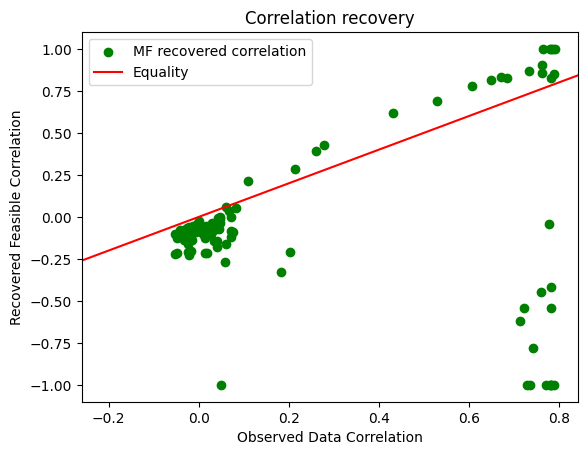

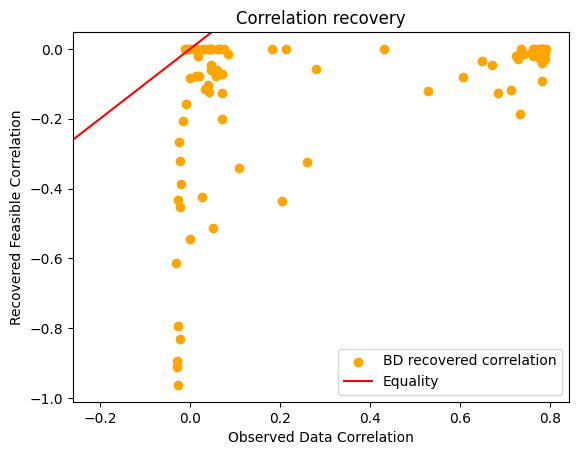

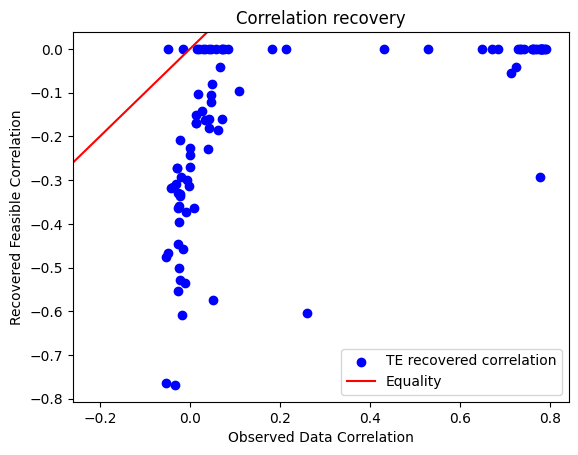

In [115]:
# display
name = ["MF", "BD", "TE"]
col = ["green", "orange", "blue"]
for i, corr in enumerate([correlations_MF, correlations_BD, correlations_TE]):
    plt.title("Correlation recovery")
    plt.xlabel("Observed Data Correlation")
    plt.ylabel("Recovered Feasible Correlation")
    plt.scatter(correlations_data, corr, color=col[i], label=f"{name[i]} recovered correlation")
    plt.axline([-0.21, -0.21], [-0.2, -0.2], color="red", label="Equality")
    plt.legend()
    plt.show()

## Feasibility

In [101]:
# extract feasibility
status_MF = [solution['status'] for solution in opt_MF.result_dict.values()]
status_BD = [solution['status'] for solution in opt_BD.result_dict.values()]
status_TE = [solution['status'] for solution in opt_TE.result_dict.values()]

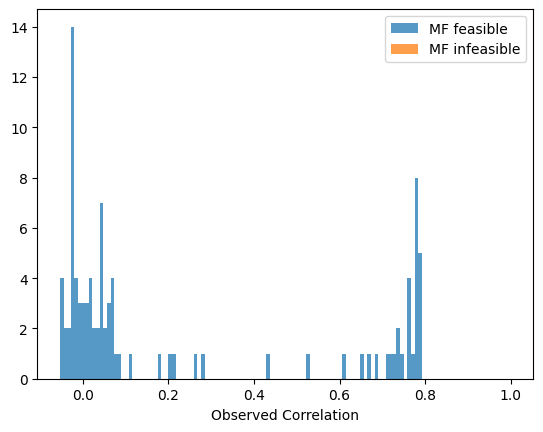

In [109]:
# display MF feasibility vs observed correlation
correlations_data_FMF = [rho for i, rho in enumerate(correlations_data) if status_MF[i] == "OPTIMAL"]
correlations_data_IMF = [rho for i, rho in enumerate(correlations_data) if status_MF[i] == "INFEASIBLE"]
plt.hist(correlations_data_FMF, bins=100, alpha=0.75, label="MF feasible")
plt.hist(correlations_data_IMF, bins=100, alpha=0.75, label="MF infeasible")
plt.xlabel("Observed Correlation")
plt.legend()
plt.show()

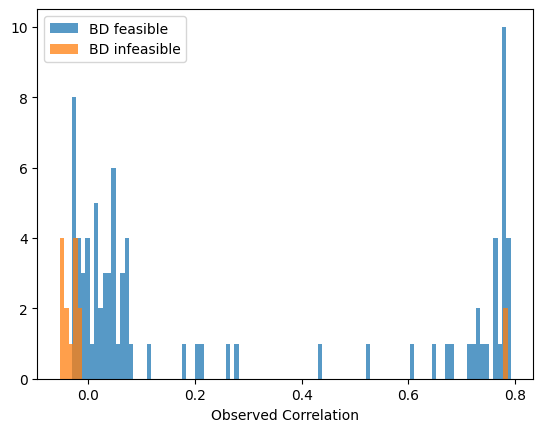

In [110]:
# display BD feasibility vs observed correlation
correlations_data_FBD = [rho for i, rho in enumerate(correlations_data) if status_BD[i] == "OPTIMAL"]
correlations_data_IBD = [rho for i, rho in enumerate(correlations_data) if status_BD[i] == "INFEASIBLE"]
plt.hist(correlations_data_FBD, bins=100, alpha=0.75, label="BD feasible")
plt.hist(correlations_data_IBD, bins=100, alpha=0.75, label="BD infeasible")
plt.xlabel("Observed Correlation")
plt.legend()
plt.show()

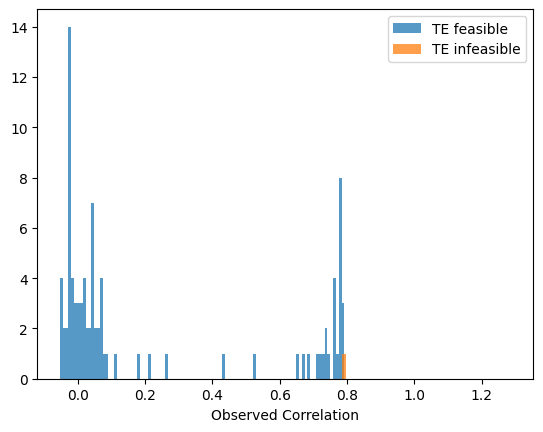

In [111]:
# display TE feasibility vs observed correlation
correlations_data_FTE = [rho for i, rho in enumerate(correlations_data) if status_TE[i] == "OPTIMAL"]
correlations_data_ITE = [rho for i, rho in enumerate(correlations_data) if status_TE[i] == "INFEASIBLE"]
plt.hist(correlations_data_FTE, bins=100, alpha=0.75, label="TE feasible")
plt.hist(correlations_data_ITE, bins=100, alpha=0.75, label="TE infeasible")
plt.xlabel("Observed Correlation")
plt.legend()
plt.show()

## Bootstrap confidence effects

95% confidence intervals above give poor results as bounds very wide (see 0.8 example for width of observed correlation)

Try 50% and 5% confidence intervals: smaller widths, more risk of false infeasibility
- MF independence test begins to have a reasonable pattern, where high and low positive observed correlations are infeasible but moderate are feasible, matching the shift of downsampling to original correlations

In [117]:
# genes
genes = 100
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc[miRNA], data_pcRNA[k:k+genes], beta)

# correlations
corr = Correlation(dataset_mir, printing=False)

100%|██████████| 100/100 [00:00<00:00, 439.64it/s]


In [488]:
def confidence_test(dataset, corr, alpha):

    # bootstrap
    d = 4
    dataset.confidence = alpha
    dataset.bootstrap(d, tqdm_disable=False)

    #settings
    d = 3
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        factorization=False
    )

    # test feasibility
    opt_MF = optimization.ModelFreeOptimization(dataset, d, constraints=constraints, printing=False, silent=True)
    opt_MF.analyse_dataset()

    #settings
    d = 3
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        factorization=False
    )
    fixed = [(1, 1)]

    # test feasibility
    opt_BD = optimization.BirthDeathOptimization(dataset, d, constraints=constraints, silent=True, fixed=fixed)
    opt_BD.analyse_dataset()

    #settings
    d = 3
    constraints = Constraint(
        moment_bounds=True,
        moment_matrices=True,
        moment_equations=True,
        telegraph_moments=True,
        telegraph_moments_ineq=True,
        telegraph_factorization=False
    )
    fixed = [(3, 1)]

    # test feasibility
    opt_TE = optimization.TelegraphOptimization(dataset, d, constraints=constraints, silent=True, fixed=fixed)
    opt_TE.analyse_dataset()

    # extract correlations
    correlations_TE = [solution['correlation'] for solution in opt_TE.result_dict.values()]
    correlations_BD = [solution['correlation'] for solution in opt_BD.result_dict.values()]
    correlations_MF = [solution['correlation'] for solution in opt_MF.result_dict.values()]
    correlations_data = [result['statistic'] for result in corr.result_dict.values()]

    # display
    name = ["MF", "BD", "TE"]
    col = ["green", "orange", "blue"]
    for i, corrs in enumerate([correlations_MF, correlations_BD, correlations_TE]):
        plt.title("Correlation recovery")
        plt.xlabel("Observed Data Correlation")
        plt.ylabel("Recovered Feasible Correlation")
        plt.scatter(correlations_data, corrs, color=col[i], label=f"{name[i]} recovered correlation")
        plt.axline([-0.21, -0.21], [-0.2, -0.2], color="red", label="Equality")
        plt.legend()
        plt.show()

    # extract feasibility
    status_MF = [solution['status'] for solution in opt_MF.result_dict.values()]
    status_BD = [solution['status'] for solution in opt_BD.result_dict.values()]
    status_TE = [solution['status'] for solution in opt_TE.result_dict.values()]

    # display MF feasibility vs observed correlation
    correlations_data_FMF = [rho for i, rho in enumerate(correlations_data) if status_MF[i] == "OPTIMAL"]
    correlations_data_IMF = [rho for i, rho in enumerate(correlations_data) if status_MF[i] == "INFEASIBLE"]
    plt.hist(correlations_data_FMF, bins=100, alpha=0.75, label="MF feasible")
    plt.hist(correlations_data_IMF, bins=100, alpha=0.75, label="MF infeasible")
    plt.xlabel("Observed Correlation")
    plt.legend()
    plt.show()

    # display BD feasibility vs observed correlation
    correlations_data_FBD = [rho for i, rho in enumerate(correlations_data) if status_BD[i] == "OPTIMAL"]
    correlations_data_IBD = [rho for i, rho in enumerate(correlations_data) if status_BD[i] == "INFEASIBLE"]
    plt.hist(correlations_data_FBD, bins=100, alpha=0.75, label="BD feasible")
    plt.hist(correlations_data_IBD, bins=100, alpha=0.75, label="BD infeasible")
    plt.xlabel("Observed Correlation")
    plt.legend()
    plt.show()

    # display TE feasibility vs observed correlation
    correlations_data_FTE = [rho for i, rho in enumerate(correlations_data) if status_TE[i] == "OPTIMAL"]
    correlations_data_ITE = [rho for i, rho in enumerate(correlations_data) if status_TE[i] == "INFEASIBLE"]
    plt.hist(correlations_data_FTE, bins=100, alpha=0.75, label="TE feasible")
    plt.hist(correlations_data_ITE, bins=100, alpha=0.75, label="TE infeasible")
    plt.xlabel("Observed Correlation")
    plt.legend()
    plt.show()

100%|██████████| 100/100 [03:50<00:00,  2.30s/it]


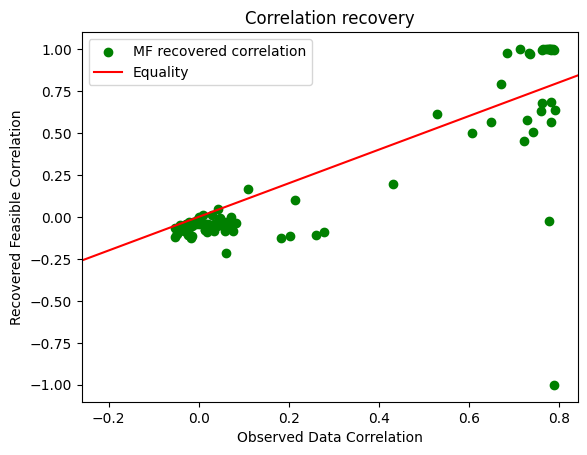

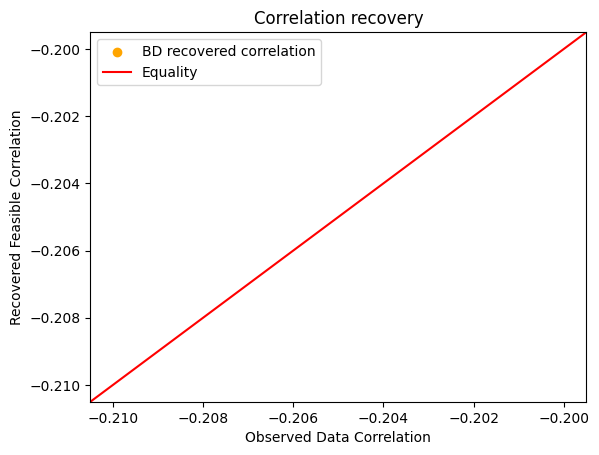

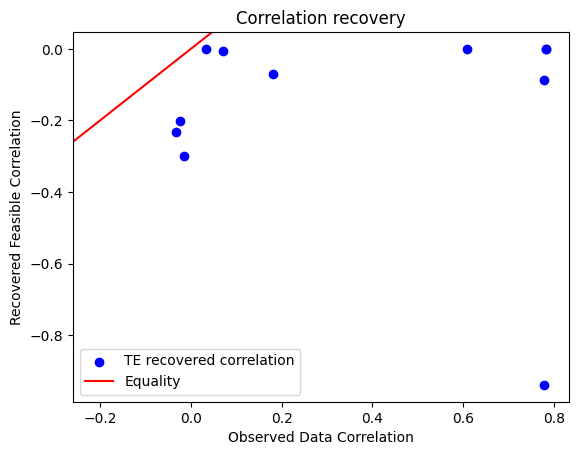

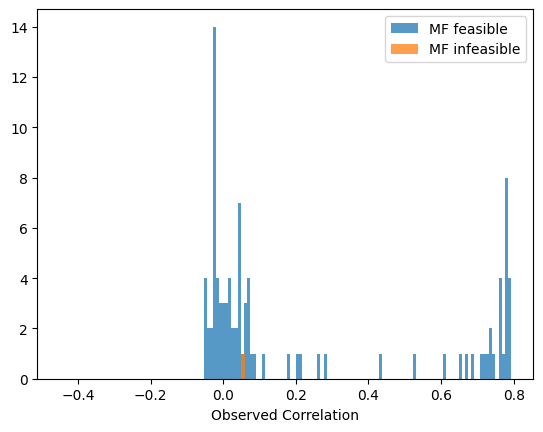

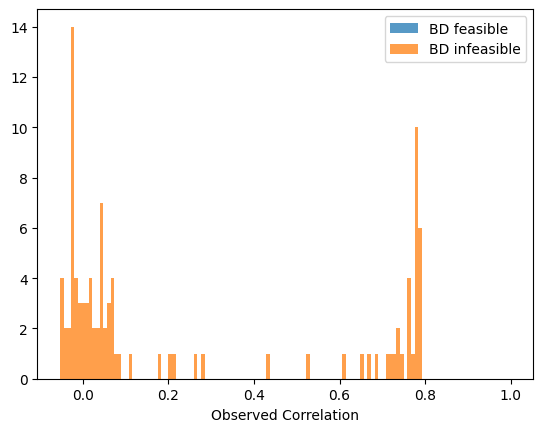

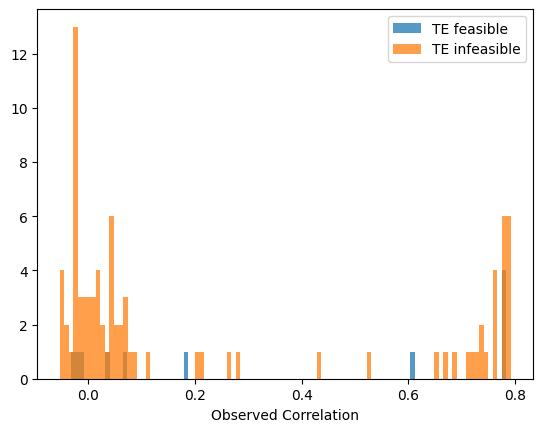

In [124]:
confidence_test(0.5)

100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


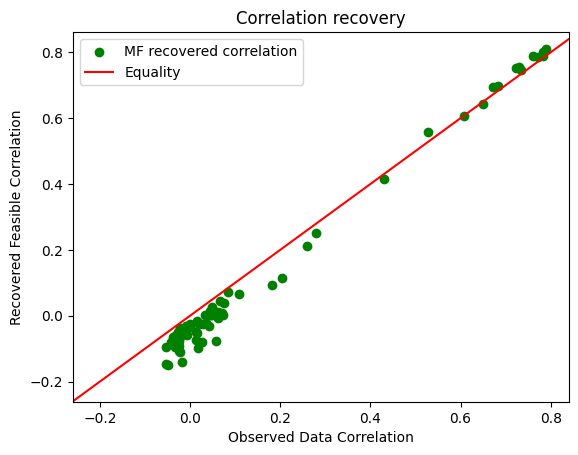

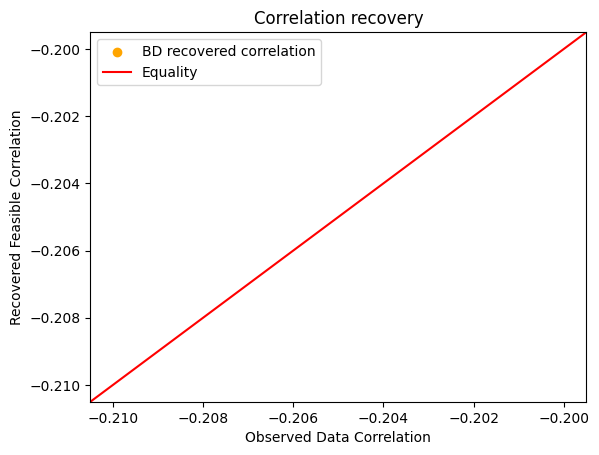

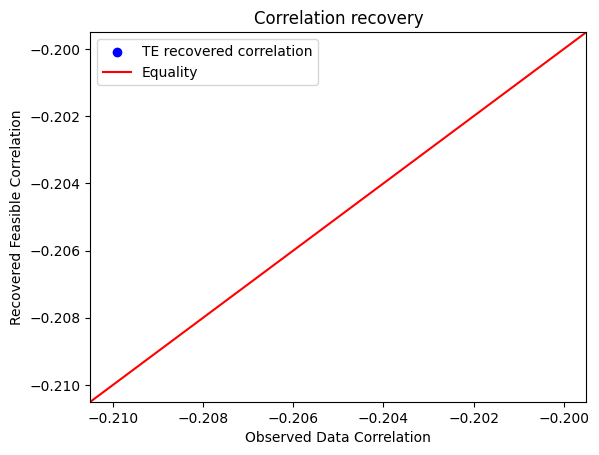

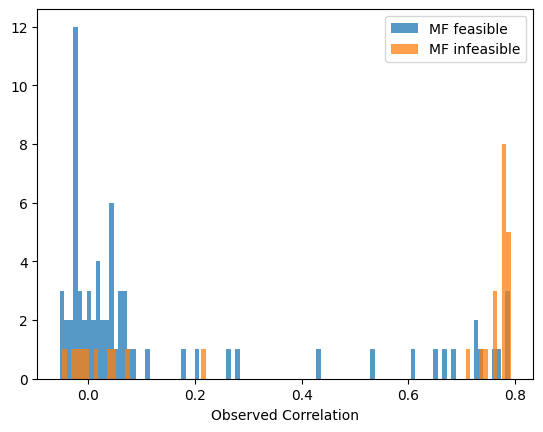

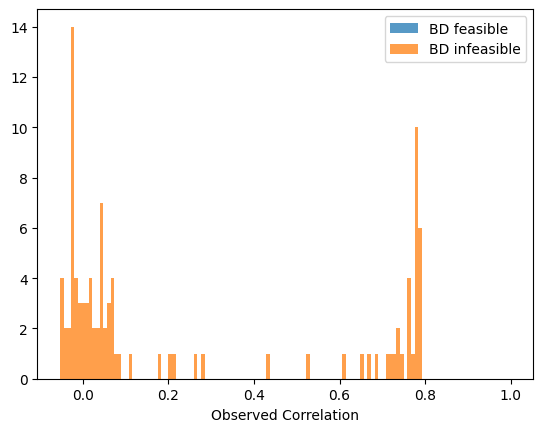

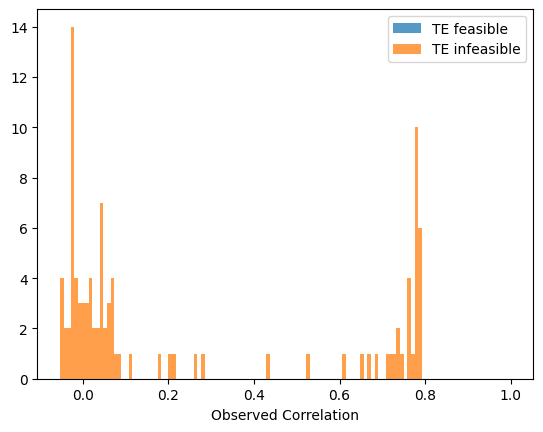

In [125]:
confidence_test(0.95)

# Individual sample: 0.8 correlation investigation

## Data exploration & Select 0.8 sample

See that almost all samples with > 0.8 correlation have a single extremely high mRNA count for the largest miRNA count. Removing this one outlying cell reduces the correlation to a much smaller value e.g. 0.2

100%|██████████| 9376/9376 [00:13<00:00, 719.95it/s]


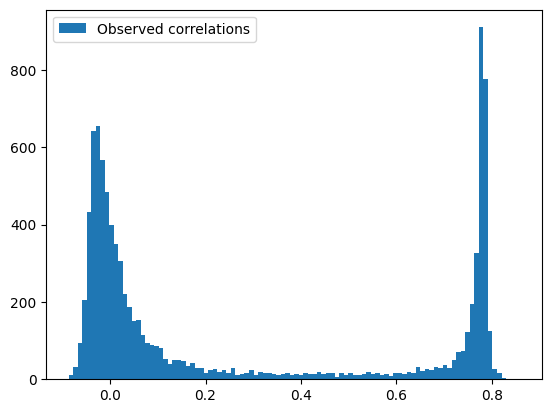

In [311]:
# genes
genes = 10000
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_mir = construct_dataset(data_miRNA.loc[miRNA], data_pcRNA[k:k+genes], beta)

# correlations
corr = Correlation(dataset_mir, printing=False)

# display
correlations_data = [result['statistic'] for result in corr.result_dict.values()]
plt.hist(correlations_data, label="Observed correlations", bins=100)
plt.legend()
plt.show()

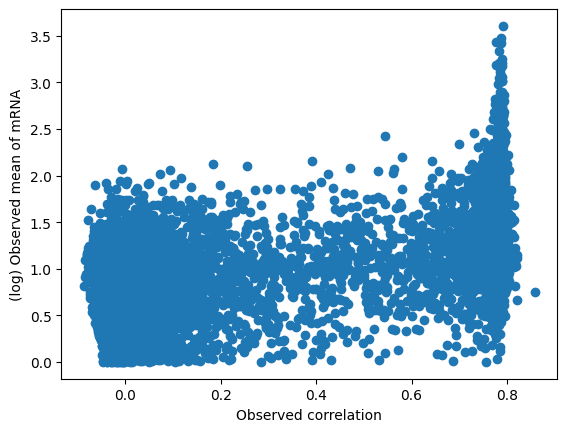

In [312]:
# mean of data
means = data_pcRNA[k:k+genes].mean(axis=1).tolist()
correlations_data = [result['statistic'] for result in corr.result_dict.values()]
plt.scatter(correlations_data, np.log10(means))
plt.xlabel("Observed correlation")
plt.ylabel("(log) Observed mean of mRNA")
plt.show()

### Outlying cell

In [ ]:
sum(data_pcRNA.mean(axis=0) >= 100)

1

In [324]:
data_pcRNA.mean(axis=0).loc['Fibroblasts_P23_S383']

np.float64(1563.5987627986349)

### Remove outlying cell

Also try removing 2 outlying cells

Significantly changes observed correlation structure

Removing 1 cell takes maximum to ~ 0.7, 2 cells to ~ 0.5

In [441]:
data_new_pcRNA = data_pcRNA.copy(deep=True)
data_new_miRNA = data_miRNA.copy(deep=True)

In [442]:
data_miRNA.loc['MIR100'][data_miRNA.loc['MIR100'] > 50]

Fibroblasts_D14_S86      59
Fibroblasts_P23_S383    105
Name: MIR100, dtype: int64

In [443]:
data_new_pcRNA = data_new_pcRNA.drop(labels=['Fibroblasts_P23_S383', 'Fibroblasts_D14_S86'], axis=1)
data_new_miRNA = data_new_miRNA.drop(labels=['Fibroblasts_P23_S383', 'Fibroblasts_D14_S86'], axis=1)

100%|██████████| 9376/9376 [00:13<00:00, 673.07it/s]


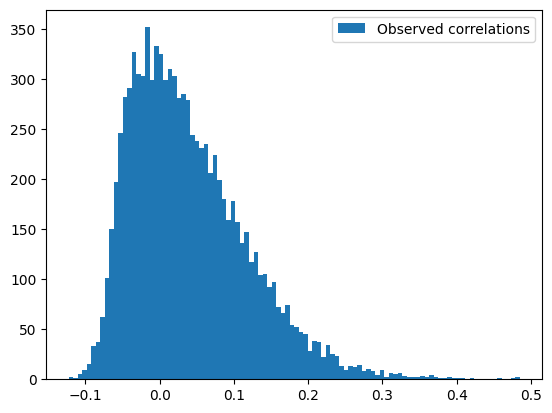

In [444]:
# genes
genes = 10000
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_new = construct_dataset(data_new_miRNA.loc[miRNA], data_new_pcRNA[k:k+genes], beta)

# correlations
corr = Correlation(dataset_new, printing=False)

# display
correlations_data = [result['statistic'] for result in corr.result_dict.values()]
plt.hist(correlations_data, label="Observed correlations", bins=100)
plt.legend()
plt.show()

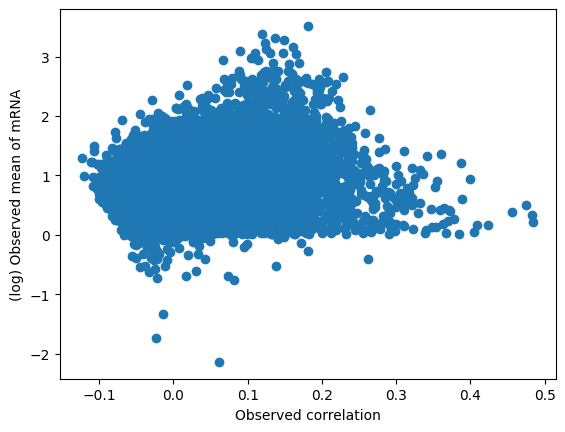

In [445]:
# mean of data
means = data_new_pcRNA[k:k+genes].mean(axis=1).tolist()
correlations_data = [result['statistic'] for result in corr.result_dict.values()]
plt.scatter(correlations_data, np.log10(means))
plt.xlabel("Observed correlation")
plt.ylabel("(log) Observed mean of mRNA")
plt.show()

In [487]:
# select a (miRNA, mRNA) pair with high correlation
#corr = [x for x in correlations_data if x > 0.45][0]
#idx = correlations_data.index(corr)
idx = 338
mRNA = data_new_pcRNA.iloc[idx].name

# get sample
sample_new_mRNA = data_new_pcRNA.loc[mRNA]
sample_new_miRNA = data_new_miRNA.loc[miRNA] 
corr = scipy.stats.pearsonr(sample_new_miRNA, sample_new_mRNA).statistic
print(f"pair {idx} ({miRNA}, {mRNA}) has correlation {corr}")

pair 338 (MIR100, ANKRD50) has correlation 0.11014737730223079


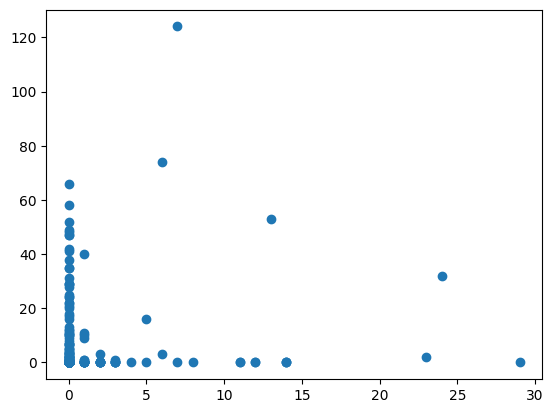

In [480]:
plt.scatter(sample_new_miRNA, sample_new_mRNA)

## Observed correlation bounds

In [481]:
def compute_correlation_bounds(moment_bounds):
    powers = utils.compute_powers(S=2, d=2)
    i_xy = powers.index([1, 1])
    i_x  = powers.index([1, 0])
    i_y  = powers.index([0, 1])
    i_x2 = powers.index([2, 0])
    i_y2 = powers.index([0, 2])

    # collect moment values
    E_xy = moment_bounds[:, i_xy]
    E_x  = moment_bounds[:, i_x]
    E_y  = moment_bounds[:, i_y]
    E_x2 = moment_bounds[:, i_x2]
    E_y2 = moment_bounds[:, i_y2]

    # compute correlation
    correlation_lb = (E_xy[0] - E_x[1]*E_y[1]) / (np.sqrt(E_x2[1] - E_x[0]**2) * np.sqrt(E_y2[1] - E_y[0]**2))
    correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))

    return correlation_lb, correlation_ub

In [482]:
# construct single sample dataset
dataset_sample = Dataset()
gene_pairs, cells = 1, len(sample_new_mRNA)
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)
counts_df.iloc[0] = list(zip(sample_new_miRNA, sample_new_mRNA))
dataset_sample.count_dataset = counts_df
dataset_sample.cells = cells
dataset_sample.gene_pairs = gene_pairs
dataset_sample.beta = beta

In [483]:
dataset_sample.confidence = 0.05 # is alpha due to mistake
dataset_sample.bootstrap(d=4)

In [484]:
correlation_lb, correlation_ub = compute_correlation_bounds(dataset_sample.moment_bounds['sample-0'])
correlation_lb, correlation_ub

(np.float64(-0.07819083597599534), np.float64(1.194743825179052))

In [485]:
def bootstrap_correlation(x1_sample, x2_sample, confidence=None, resamples=None):

    # get sample size
    n = len(x1_sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n
    # confidence level: default to 95%
    if confidence is None:
        confidence = 0.95

    # initialize random generator
    rng = np.random.default_rng()

    # separate sample pairs
    x1_sample = list(x1_sample)
    x2_sample = list(x2_sample)

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to N x n x 2 array
    boot = rng.choice(sample, size=(resamples, n))

    # compute correlations
    estimates = np.zeros(resamples)
    for i in range(resamples):

        b1 = boot[i, :, 0]
        b2 = boot[i, :, 1]

        E_xy = np.mean(b1 * b2)
        E_x = np.mean(b1)
        E_y = np.mean(b2)
        E_x2 = np.mean(b1**2)
        E_y2 = np.mean(b2**2)

        corr = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))

        #test = scipy.stats.pearsonr(boot[i, :, 0], boot[i, :, 1])
        estimates[i] = corr#test.statistic

    # take quantiles
    alpha = 1 - confidence
    interval = np.quantile(estimates, [(alpha / 2), 1 - (alpha / 2)])

    return interval

In [486]:
bootstrap_correlation(sample_new_miRNA, sample_new_mRNA, confidence=0.95)

array([-0.0611292 ,  0.26643503])

- correlation allows under moment bounds (compute statistic using upper and lower values) has extremely wide range
    - [(small negative), (large positive)] (typically not even restricted to 1)
- still quite wide, even under direct boostrap (interval directly on statistic)
    - including outlying cells was also very wide [0, 1]
    - reduced to more reasonable range when removed

### Old sample with high correlation

In [472]:
# select a (miRNA, mRNA) pair with high correlation
idx = 338
mRNA = data_pcRNA.iloc[idx].name

# get sample
sample_mRNA = data_pcRNA.loc[mRNA]
sample_miRNA = data_miRNA.loc[miRNA]

corr = scipy.stats.pearsonr(sample_miRNA, sample_mRNA).statistic
print(f"pair {idx} ({miRNA}, {mRNA}) has correlation {corr} (no cells removed)")

pair 338 (MIR100, ANKRD50) has correlation 0.8125804509612271 (no cells removed)


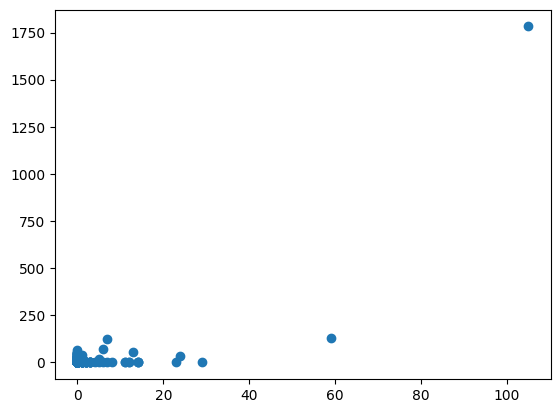

In [473]:
plt.scatter(sample_miRNA, sample_mRNA)

In [475]:
# construct single sample dataset
dataset_sample = Dataset()
gene_pairs, cells = 1, len(sample_mRNA)
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)
counts_df.iloc[0] = list(zip(sample_miRNA, sample_mRNA))
dataset_sample.count_dataset = counts_df
dataset_sample.cells = cells
dataset_sample.gene_pairs = gene_pairs
dataset_sample.beta = beta

In [476]:
dataset_sample.confidence = 0.05 # is alpha due to mistake
dataset_sample.bootstrap(d=4)

In [477]:
correlation_lb, correlation_ub = compute_correlation_bounds(dataset_sample.moment_bounds['sample-0'])
correlation_lb, correlation_ub

C:\Users\willi\AppData\Local\Temp\ipykernel_33712\3854589402.py:18: RuntimeWarning: invalid value encountered in sqrt
  correlation_ub = (E_xy[1] - E_x[0]*E_y[0]) / (np.sqrt(E_x2[0] - E_x[1]**2) * np.sqrt(E_y2[0] - E_y[1]**2))


(np.float64(-0.025945966058359995), np.float64(nan))

In [478]:
bootstrap_correlation(sample_new_miRNA, sample_new_mRNA, confidence=0.95)

array([0.08992006, 0.71569963])

# Feasibility results vs Observed correlations (Outlying cells removed)

Repeat the large scale test above with 2 outlying cells removed

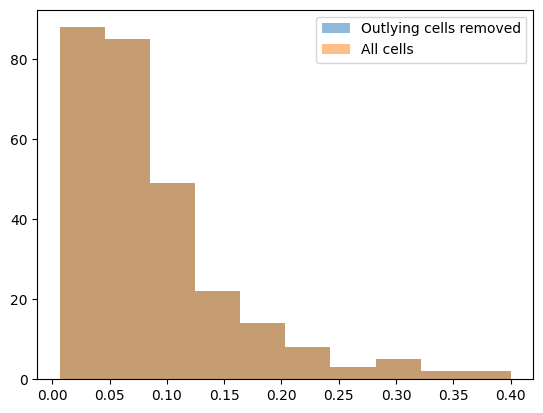

In [493]:
beta_drop = estimate_capture(data_FIB)
plt.hist(beta_drop, alpha=0.5, label="Outlying cells removed")
plt.hist(beta, alpha=0.5, label="All cells")
plt.legend()
plt.show()

In [494]:
# genes
genes = 100
k = 0
miRNA = "MIR100"

# construct dataset of the miRNA paired with mRNA (NOTE: not actually using target scan targets)
dataset_drop = construct_dataset(data_new_miRNA.loc[miRNA], data_new_pcRNA[k:k+genes], beta_drop)

# correlations
corr_drop = Correlation(dataset_drop, printing=False)

100%|██████████| 100/100 [00:00<00:00, 691.61it/s]


100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


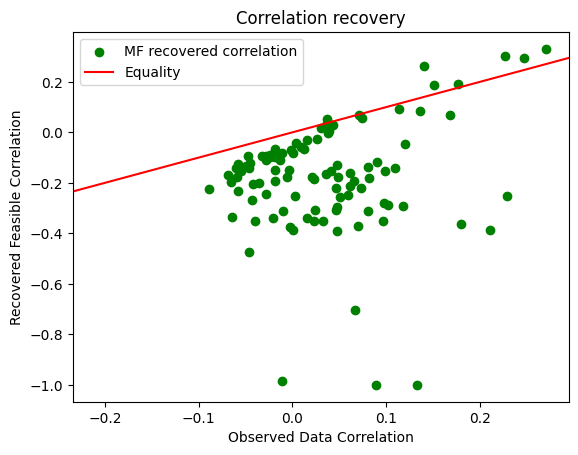

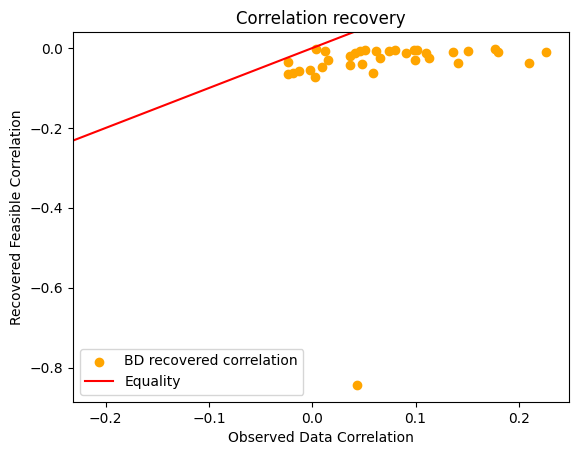

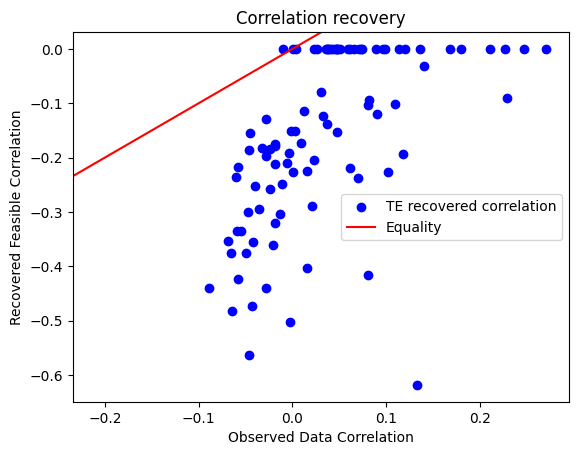

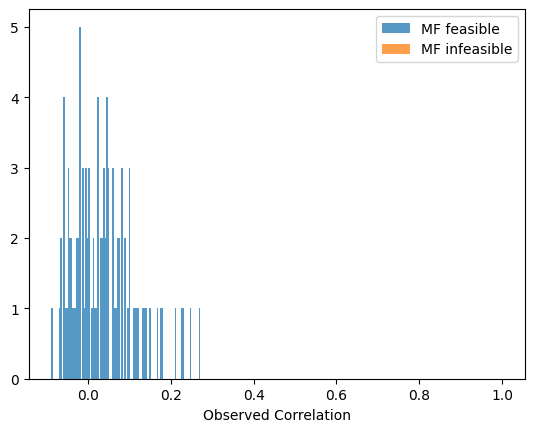

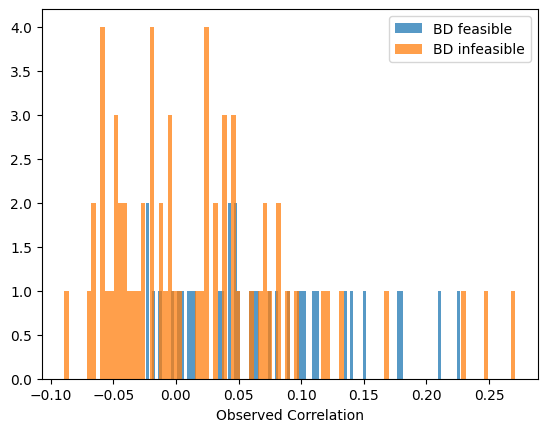

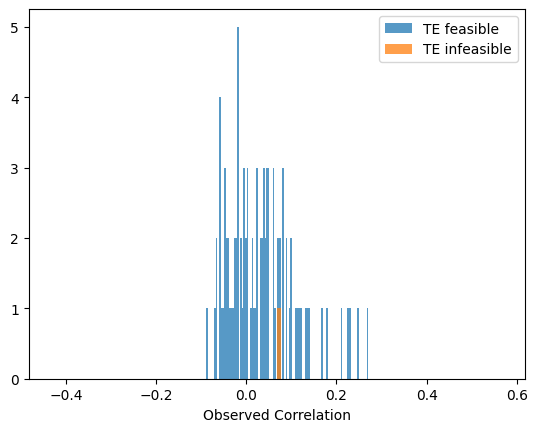

In [495]:
confidence_test(dataset_drop, corr_drop, 0.05)

100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


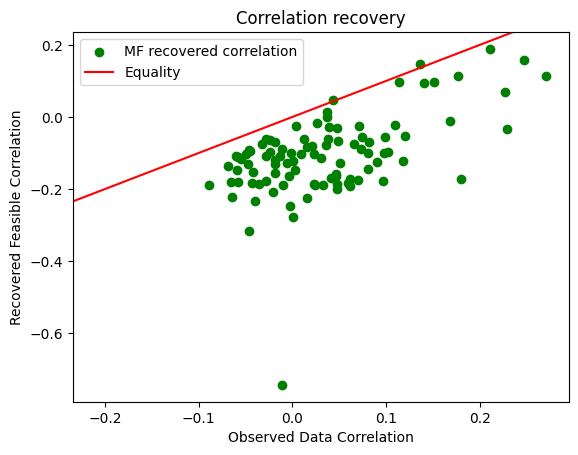

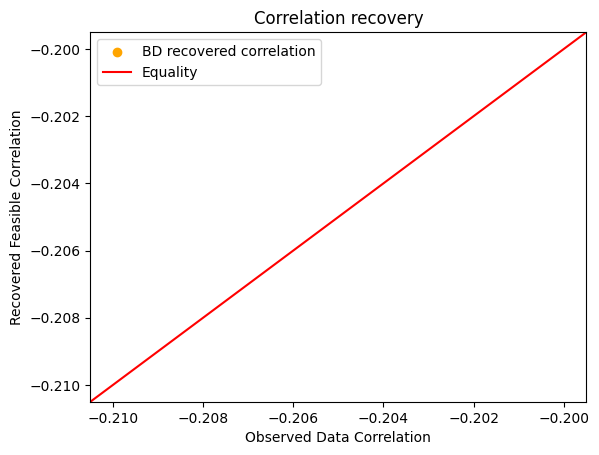

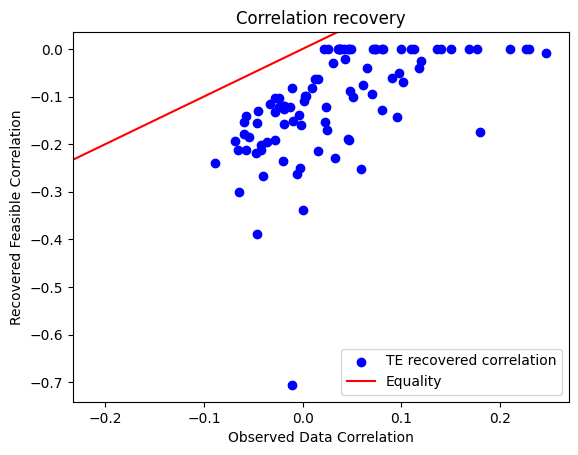

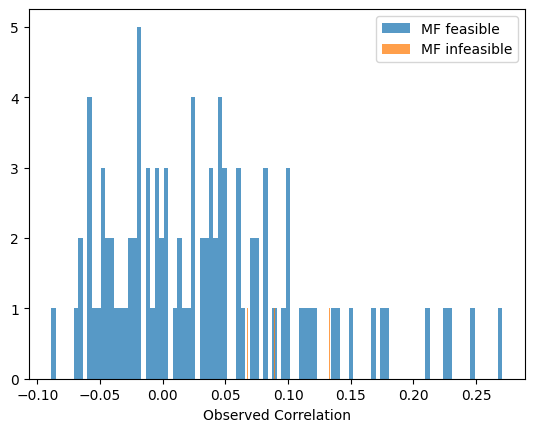

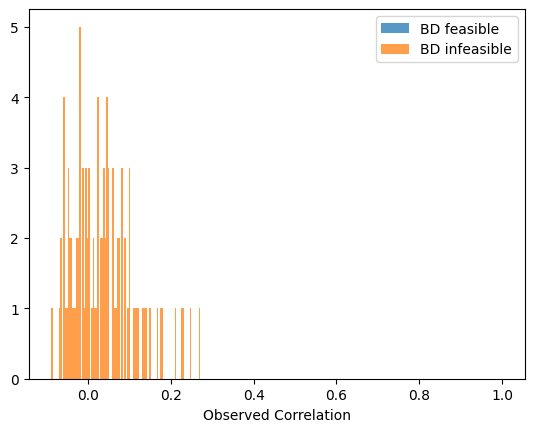

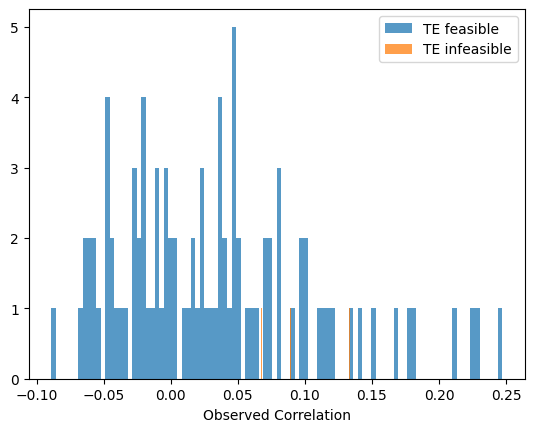

In [499]:
confidence_test(dataset_drop, corr_drop, 0.5)

100%|██████████| 100/100 [53:37<00:00, 32.17s/it]  


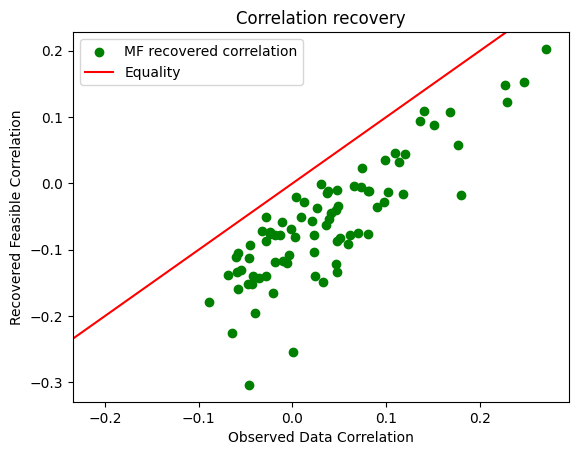

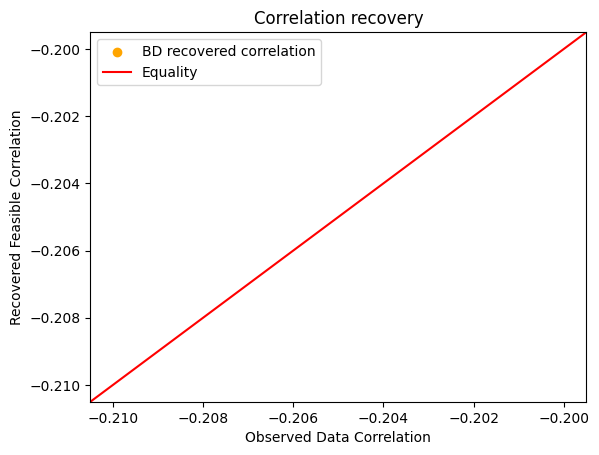

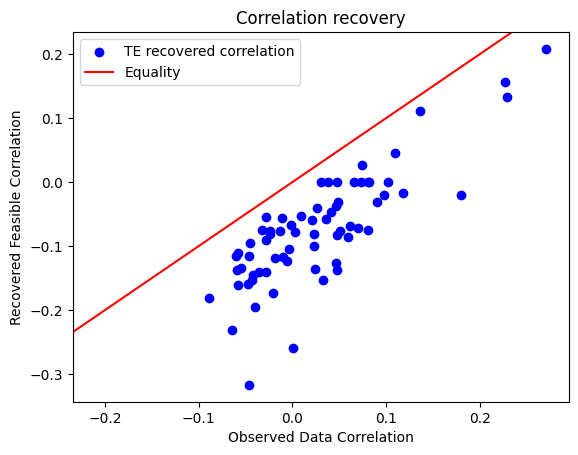

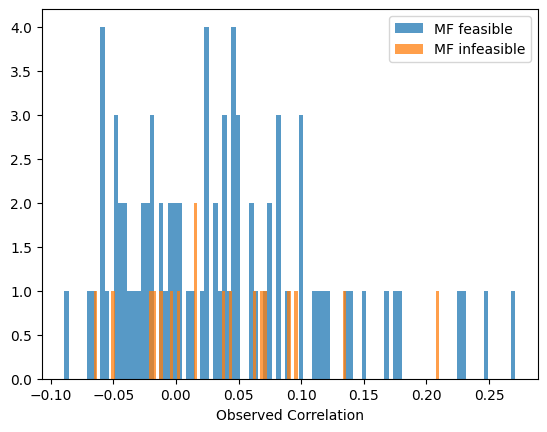

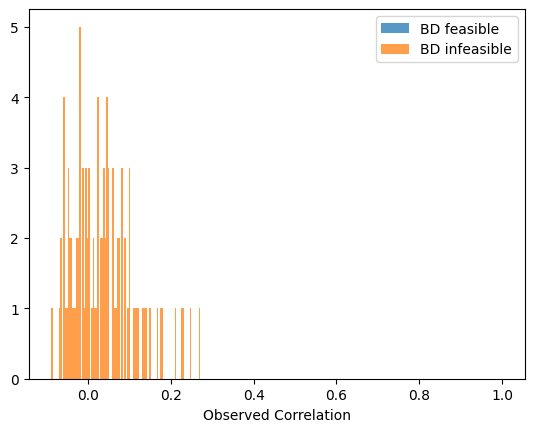

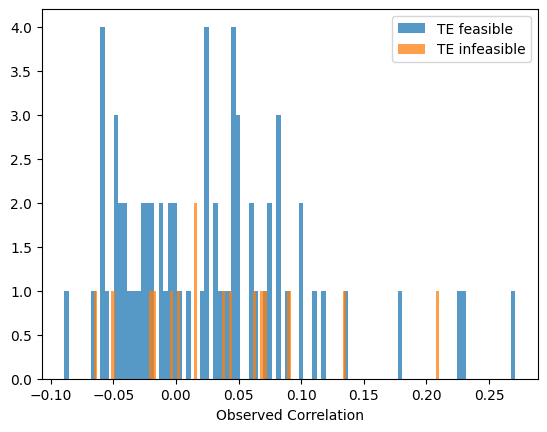

In [500]:
confidence_test(dataset_drop, corr_drop, 0.95)